In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pickle
try:
    import faiss
except:
    pass

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix

Custom function to plot the confusion matrices

In [2]:
def plot_cm_subplots(cm_dict, suptitle=None, y1=0, y2=0.95, new_title=None):
    
    fig, axes = plt.subplots(1, len(cm_dict), figsize=(20, 5), sharey='row')
        
    for i, (key, cf_matrix) in enumerate(cm_dict.items()):
        disp = ConfusionMatrixDisplay(cf_matrix, display_labels=['Arrest','No Action'])
        disp.plot(ax=axes[i], xticks_rotation=45)
        if new_title != None:
            disp.ax_.set_title(new_title + f'{key}')
        else:
            disp.ax_.set_title(f'Confusion matrix for the {key} set')
        disp.im_.colorbar.remove()
        disp.ax_.set_xlabel('')
        if i!=0:
            disp.ax_.set_ylabel('')
            
    plt.subplots_adjust(wspace=0.40, hspace=0.1)
    cbar = fig.colorbar(disp.im_, ax=axes)
    cbar.set_ticks([])

    if len(cm_dict) % 2 != 0:
        j = int(np.floor(len(cm_dict)/2))
        ax_pos = axes[j].get_position()
        x_pos = (ax_pos.x0 + ax_pos.x1) / 2
    else:
        j = int((len(cm_dict) / 2) - 1)
        k = int(len(cm_dict) / 2)
        ax_pos_1 = axes[j].get_position()
        ax_pos_2 = axes[k].get_position()
        x_pos_1 = ax_pos_1.x1
        x_pos_2 = ax_pos_2.x0
        x_pos = (x_pos_1 + x_pos_2) / 2
            
    fig.text(x_pos, y1, 'Predicted label', ha='center')

    if suptitle != None:
        fig.text(x_pos, y2, suptitle, ha='center', fontsize=20)
    
    plt.show()

Defining a KNN classifier using the faiss library for fast computation

In [3]:
# Use an external library from Facebook to speed up the computation
# Source: https://towardsdatascience.com/make-knn-300-times-faster-than-scikit-learns-in-20-lines-5e29d74e76bb
# git: https://github.com/facebookresearch/faiss/blob/master/INSTALL.md
class FaissKNeighbors:
    def __init__(self, k=5):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, X, y):
        self.index = faiss.IndexFlatL2(X.shape[1])
        self.index.add(X)
        self.y = y

    def predict(self, X):
        distances, indices = self.index.search(X, k=self.k)
        votes = self.y[indices]
        predictions = np.array([np.argmax(np.bincount(x)) for x in votes])
        return predictions

Loading the pre-computed results from pickle files into variables to avoid repeated training and prediction

In [70]:
knn_sklearn = pickle.load(open('pickles/knn_sklearn.sav', 'rb'))
y_pred_train_knn_sklearn = pickle.load(open('pickles/y_pred_train_knn_sklearn.sav', 'rb'))
y_pred_val_knn_sklearn = pickle.load(open('pickles/y_pred_val_knn_sklearn.sav', 'rb'))
y_pred_test_knn_sklearn = pickle.load(open('pickles/y_pred_test_knn_sklearn.sav', 'rb'))

# Run faiss class initalization first otherwise you receive an error
knn_faiss = pickle.load(open('pickles/knn_faiss.sav', 'rb'))
y_pred_train_knn_faiss = pickle.load(open('pickles/y_pred_train_knn_faiss.sav', 'rb'))
y_pred_val_knn_faiss = pickle.load(open('pickles/y_pred_val_knn_faiss.sav', 'rb'))
y_pred_test_knn_faiss = pickle.load(open('pickles/y_pred_test_knn_faiss.sav', 'rb'))

nn_sklearn = pickle.load(open('pickles/nn_sklearn.sav', 'rb'))
y_pred_train_nn_sklearn = pickle.load(open('pickles/y_pred_train_nn_sklearn.sav', 'rb'))
y_pred_val_nn_sklearn = pickle.load(open('pickles/y_pred_val_nn_sklearn.sav', 'rb'))
y_pred_test_nn_sklearn = pickle.load(open('pickles/y_pred_test_nn_sklearn.sav', 'rb'))

train_sizes_knn = pickle.load(open('pickles/train_sizes_knn.sav', 'rb'))
train_scores_knn = pickle.load(open('pickles/train_scores_knn.sav', 'rb'))
test_scores_knn = pickle.load(open('pickles/test_scores_knn.sav', 'rb'))
fit_times_knn = pickle.load(open('pickles/fit_times_knn.sav', 'rb'))

train_sizes_nn = pickle.load(open('pickles/train_sizes_nn.sav', 'rb'))
train_scores_nn = pickle.load(open('pickles/train_scores_nn.sav', 'rb'))
test_scores_nn = pickle.load(open('pickles/test_scores_nn.sav', 'rb'))
fit_times_nn = pickle.load(open('pickles/fit_times_nn.sav', 'rb'))

knn_norace = pickle.load(open('pickles/knn_norace.sav', 'rb'))
y_pred_train_norace = pickle.load(open('pickles/y_pred_train_norace.sav', 'rb'))
y_pred_val_norace = pickle.load(open('pickles/y_pred_val_norace.sav', 'rb'))
y_pred_test_norace = pickle.load(open('pickles/y_pred_test_norace.sav', 'rb'))

knn_noage = pickle.load(open('pickles/knn_noage.sav', 'rb'))
y_pred_train_noage = pickle.load(open('pickles/y_pred_train_noage.sav', 'rb'))
y_pred_val_noage = pickle.load(open('pickles/y_pred_val_noage.sav', 'rb'))
y_pred_test_noage = pickle.load(open('pickles/y_pred_test_noage.sav', 'rb'))

knn_nogender = pickle.load(open('pickles/knn_nogender.sav', 'rb'))
y_pred_train_nogender = pickle.load(open('pickles/y_pred_train_nogender.sav', 'rb'))
y_pred_val_nogender = pickle.load(open('pickles/y_pred_val_nogender.sav', 'rb'))
y_pred_test_nogender = pickle.load(open('pickles/y_pred_test_nogender.sav', 'rb'))

knn_unaw = pickle.load(open('pickles/knn_unaw.sav', 'rb'))
y_pred_train_unaw = pickle.load(open('pickles/y_pred_train_unaw.sav', 'rb'))
y_pred_val_unaw = pickle.load(open('pickles/y_pred_val_unaw.sav', 'rb'))
y_pred_test_unaw = pickle.load(open('pickles/y_pred_test_unaw.sav', 'rb'))

/Users/brigittajesica/JesicaPraktikumPython/anaconda3/envs/tumpraktikum/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.0 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/brigittajesica/JesicaPraktikumPython/anaconda3/envs/tumpraktikum/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.24.0 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/brigittajesica/JesicaPraktikumPython/anaconda3/envs/tumpraktikum/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.24.0 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


# Preprocessing

In [5]:
#read in data for preprocessing
data = pd.read_csv("NC_policing.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402087 entries, 0 to 402086
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   state               402087 non-null  object 
 1   stop_date           402087 non-null  object 
 2   driver_gender       402087 non-null  object 
 3   driver_age          401996 non-null  float64
 4   driver_race_raw     402087 non-null  object 
 5   driver_race         402087 non-null  object 
 6   violation           402087 non-null  object 
 7   search_type         402087 non-null  object 
 8   contraband_found    402087 non-null  bool   
 9   stop_outcome        402087 non-null  object 
 10  search_basis        402087 non-null  object 
 11  officer_id          402087 non-null  int64  
 12  drugs_related_stop  4379 non-null    object 
 13  district            402049 non-null  object 
dtypes: bool(1), float64(1), int64(1), object(11)
memory usage: 40.3+ MB


In [6]:
#changing 'stop_date' feature to datetime in order to extract days of week
#as a feature. Instead of using "dates" we use "days of week"
#idea behind it: there can be a trend regarding occurances of arrest on
#specific days of week e.g. monday because it is first day of the week 
#and everyone is grumpy, or weekends when people are loose (eventually more
#drunk)
data['stop_date'] = pd.to_datetime(data['stop_date'], errors = 'coerce')
data['stop_date:day_of_week'] = data['stop_date'].dt.day_of_week
data.head()

,state,stop_date,driver_gender,driver_age,driver_race_raw,driver_race,violation,search_type,contraband_found,stop_outcome,search_basis,officer_id,drugs_related_stop,district,stop_date:day_of_week
0,NC,2000-07-31,M,23.0,W N,White,Speeding,No Search Conducted,False,Arrest,No Search Conducted,10606,NaN,E3,0
1,NC,2000-07-31,F,29.0,W N,White,Speeding,No Search Conducted,False,Arrest,No Search Conducted,10606,NaN,E3,0
2,NC,2000-07-31,F,49.0,B N,Black,Speeding,No Search Conducted,False,Arrest,No Search Conducted,10606,NaN,E3,0
3,NC,2000-07-31,M,29.0,B N,Black,Speeding,No Search Conducted,False,Arrest,No Search Conducted,10606,NaN,E3,0
4,NC,2000-07-31,M,24.0,U H,Hispanic,Speeding,No Search Conducted,False,Arrest,No Search Conducted,10606,NaN,E3,0


In [7]:
#check number of NaN values in each column
data.isna().sum()

state                         0
stop_date                     0
driver_gender                 0
driver_age                   91
driver_race_raw               0
driver_race                   0
violation                     0
search_type                   0
contraband_found              0
stop_outcome                  0
search_basis                  0
officer_id                    0
drugs_related_stop       397708
district                     38
stop_date:day_of_week         0
dtype: int64

In [8]:
#fill missing values in "drivers_age" feature with mean of all values
age_fill = data['driver_age'].mean()
print("Average age:", age_fill)

#mean drivers age is 41.8, we round it to 42 since age can't be 
#looked at with decimal points
data['driver_age'] = data['driver_age'].fillna(int(np.rint(age_fill)))

#fill missing values in "drugs_related_stop" feature with false values
#since the probability of finding drugs in someone's car is low
data['drugs_related_stop'] = data['drugs_related_stop'].fillna(False)

#dropping rows which dont have a specified district
#since its only 38 of those, it won't have an impact
#on the quality of data
data.dropna(axis=0, inplace=True)

#check whether there are still missing values
data.isna().sum()

Average age: 41.878103264709104


state                    0
stop_date                0
driver_gender            0
driver_age               0
driver_race_raw          0
driver_race              0
violation                0
search_type              0
contraband_found         0
stop_outcome             0
search_basis             0
officer_id               0
drugs_related_stop       0
district                 0
stop_date:day_of_week    0
dtype: int64

In [9]:
#see which unique values do the columns of our dataset hold
for col in data:
    print(data[col].unique())

['NC']
['2000-07-31T00:00:00.000000000' '2000-08-01T00:00:00.000000000'
 '2000-08-02T00:00:00.000000000' ... '2015-12-29T00:00:00.000000000'
 '2015-12-30T00:00:00.000000000' '2015-12-31T00:00:00.000000000']
['M' 'F']
[23. 29. 49. 24. 21. 33. 16. 28. 39. 68. 20. 40. 50. 57. 38. 46. 34. 44.
 22. 36. 53. 32. 15. 27. 26. 41. 48. 25. 47. 42. 52. 17. 76. 61. 31. 30.
 64. 37. 19. 51. 18. 35. 59. 73. 43. 45. 66. 65. 54. 58. 55. 75. 63. 56.
 60. 81. 62. 77. 67. 69. 87. 70. 71. 78. 74. 85. 72. 79. 93. 80. 89. 82.
 84. 91. 83. 90. 88. 86. 92. 98. 99. 94. 96.]
['W N' 'B N' 'U H' 'W H' 'I N' 'U N' 'A N' 'A H' 'B H' 'I H']
['White' 'Black' 'Hispanic' 'Other' 'Asian']
['Speeding' 'DUI' 'Equipment' 'Seat belt' 'Other' 'Registration/plates'
 'Safe movement' 'Stop sign/light']
['No Search Conducted' 'Protective Frisk' 'Incident to Arrest' 'Consent'
 'Probable Cause' 'Warrant']
[False  True]
['Arrest' 'No Action']
['No Search Conducted' 'Observation Suspected Contraband'
 'Erratic Suspicious Behaviour' '

In [10]:
# After dropping some columns
data.head()

,state,stop_date,driver_gender,driver_age,driver_race_raw,driver_race,violation,search_type,contraband_found,stop_outcome,search_basis,officer_id,drugs_related_stop,district,stop_date:day_of_week
0,NC,2000-07-31,M,23.0,W N,White,Speeding,No Search Conducted,False,Arrest,No Search Conducted,10606,False,E3,0
1,NC,2000-07-31,F,29.0,W N,White,Speeding,No Search Conducted,False,Arrest,No Search Conducted,10606,False,E3,0
2,NC,2000-07-31,F,49.0,B N,Black,Speeding,No Search Conducted,False,Arrest,No Search Conducted,10606,False,E3,0
3,NC,2000-07-31,M,29.0,B N,Black,Speeding,No Search Conducted,False,Arrest,No Search Conducted,10606,False,E3,0
4,NC,2000-07-31,M,24.0,U H,Hispanic,Speeding,No Search Conducted,False,Arrest,No Search Conducted,10606,False,E3,0


In [11]:
#data['district'].value_counts()
#previous row shows the number of value-occurances in column

#since we can't work with string values for machine learning 
#we have to convert all non-numerical features to numerical ones
#especially features labeled as sensitive: gender, race, ...

#we drop the features not going to be used for ML
X = data.drop(columns=["state", "stop_date", "driver_race_raw", "stop_outcome"])
columns = X.columns
X

,driver_gender,driver_age,driver_race,violation,search_type,contraband_found,search_basis,officer_id,drugs_related_stop,district,stop_date:day_of_week
0,M,23.0,White,Speeding,No Search Conducted,False,No Search Conducted,10606,False,E3,0
1,F,29.0,White,Speeding,No Search Conducted,False,No Search Conducted,10606,False,E3,0
2,F,49.0,Black,Speeding,No Search Conducted,False,No Search Conducted,10606,False,E3,0
3,M,29.0,Black,Speeding,No Search Conducted,False,No Search Conducted,10606,False,E3,0
4,M,24.0,Hispanic,Speeding,No Search Conducted,False,No Search Conducted,10606,False,E3,0
...,...,...,...,...,...,...,...,...,...,...,...
402082,M,18.0,White,Speeding,Probable Cause,True,Observation Suspected Contraband,21715,True,G3,3
402083,F,21.0,Black,Registration/plates,Incident to Arrest,False,Other Official Info,10592,False,G5,3
402084,F,29.0,White,Speeding,Incident to Arrest,False,Observation Suspected Contraband,21848,False,E1,3
402085,F,18.0,White,Other,Probable Cause,True,Observation Suspected Contraband,11887,True,F5,3


In [12]:
#encode all features except driver's age, officer id and day of the week
le = LabelEncoder()

for col in X:
    if col=='driver_age' or col=='stop_date:day_of_week' or col=='driver_race':
        pass
    else:
        X[col] = le.fit_transform(X[col])

X.head()

,driver_gender,driver_age,driver_race,violation,search_type,contraband_found,search_basis,officer_id,drugs_related_stop,district,stop_date:day_of_week
0,1,23.0,White,6,2,0,18,722,0,34,0
1,0,29.0,White,6,2,0,18,722,0,34,0
2,0,49.0,Black,6,2,0,18,722,0,34,0
3,1,29.0,Black,6,2,0,18,722,0,34,0
4,1,24.0,Hispanic,6,2,0,18,722,0,34,0


In [13]:
tmp = X[['driver_race']]
tmp = pd.get_dummies(tmp)
X = X.drop(columns=['driver_race'])
X = pd.concat([X, tmp], axis=1)
X

,driver_gender,driver_age,violation,search_type,contraband_found,search_basis,officer_id,drugs_related_stop,district,stop_date:day_of_week,driver_race_Asian,driver_race_Black,driver_race_Hispanic,driver_race_Other,driver_race_White
0,1,23.0,6,2,0,18,722,0,34,0,0,0,0,0,1
1,0,29.0,6,2,0,18,722,0,34,0,0,0,0,0,1
2,0,49.0,6,2,0,18,722,0,34,0,0,1,0,0,0
3,1,29.0,6,2,0,18,722,0,34,0,0,1,0,0,0
4,1,24.0,6,2,0,18,722,0,34,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402082,1,18.0,6,3,1,19,2632,1,46,3,0,0,0,0,1
402083,0,21.0,3,1,0,25,711,0,48,3,0,1,0,0,0
402084,0,29.0,6,1,0,19,2738,0,32,3,0,0,0,0,1
402085,0,18.0,2,3,1,19,1873,1,43,3,0,0,0,0,1


In [14]:
#target variable y to classify arrest, encoded
y = data["stop_outcome"]
y_encoded = le.fit_transform(y)

#show coding
pd.DataFrame(data=le.transform(le.classes_),index=le.classes_,columns=["Coding"])

,Coding
Arrest,0
No Action,1


In [15]:
#for standard scaling later, we convert all data types to float32
X = X.astype(np.float32)

# Split the data into training and test set
# test_size=0.2: 60% training set, 20% test set, 20% CV
# random_state=350: fix the random set to get the same result every time you run the code (for tutorial purposes)
X_tmp, X_test, y_tmp, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=350)
X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size=0.25, random_state=350)

In [16]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(241229, 15)
(80410, 15)
(80410, 15)


### Standardizing the data

In [17]:
# Creating a scaler object (here with default settings)
scaler = StandardScaler()

# Replacing the values in our X_train by the normalized ones
X_train_norm = X_train.copy()
X_train_norm.values[:] = scaler.fit_transform(X_train)
# Replacing the values in our X_test by the normalized ones
X_test_norm = X_test.copy()
X_test_norm.values[:] = scaler.transform(X_test)
# Replacing the values in our X_val by the normalized ones
X_val_norm = X_test.copy()
X_val_norm.values[:] = scaler.transform(X_val)

X_train_norm

,driver_gender,driver_age,violation,search_type,contraband_found,search_basis,officer_id,drugs_related_stop,district,stop_date:day_of_week,driver_race_Asian,driver_race_Black,driver_race_Hispanic,driver_race_Other,driver_race_White
376090,0.323003,0.315311,-0.170781,0.180831,-0.130247,0.088705,0.049197,-0.104827,0.079392,0.641341,-0.066466,-0.587797,-0.287442,-0.144067,0.746479
381498,0.323003,-0.222630,-0.170781,0.180831,-0.130247,0.088705,0.165899,-0.104827,0.807083,0.110470,-0.066466,-0.587797,-0.287442,-0.144067,0.746479
155966,0.323003,-0.991118,-0.170781,0.180831,-0.130247,0.088705,1.038166,-0.104827,0.503878,-0.420400,-0.066466,-0.587797,-0.287442,-0.144067,0.746479
148275,0.323003,-1.067967,-0.170781,0.180831,-0.130247,0.088705,-0.847009,-0.104827,0.140033,-0.420400,-0.066466,1.701267,-0.287442,-0.144067,-1.339623
344347,0.323003,-0.606874,-0.170781,0.180831,-0.130247,0.088705,0.613253,-0.104827,0.564519,1.703081,-0.066466,-0.587797,-0.287442,-0.144067,0.746479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340621,0.323003,-0.068933,-0.170781,0.180831,-0.130247,0.088705,0.435209,-0.104827,0.807083,-0.420400,-0.066466,-0.587797,-0.287442,-0.144067,0.746479
106869,0.323003,-0.299479,-0.170781,0.180831,-0.130247,0.088705,0.786809,-0.104827,-0.284453,-1.482141,-0.066466,-0.587797,3.478958,-0.144067,-1.339623
92828,0.323003,-0.530026,-0.170781,0.180831,-0.130247,0.088705,-1.316806,-0.104827,0.867724,-0.951271,-0.066466,-0.587797,-0.287442,-0.144067,0.746479
37632,0.323003,-1.144816,-0.170781,0.180831,-0.130247,0.088705,1.005250,-0.104827,1.110287,-0.951271,-0.066466,-0.587797,-0.287442,-0.144067,0.746479


# Plotting

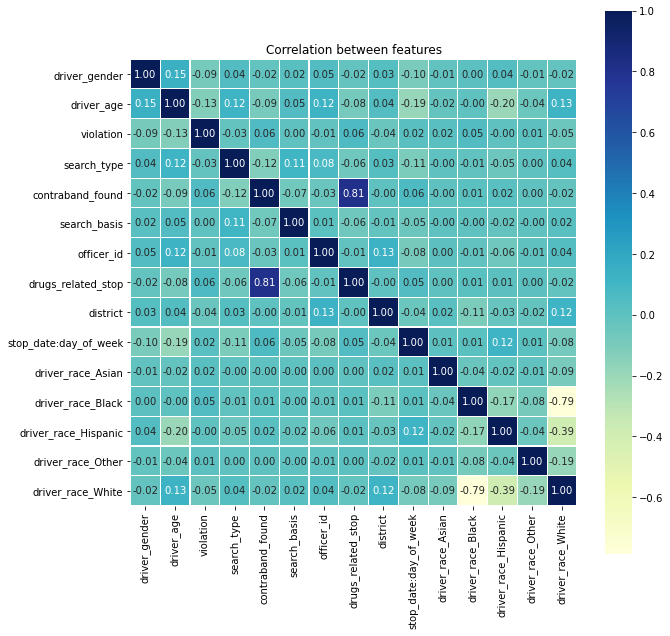

In [18]:
#creating correlation matrix for feature selection
corr = X.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, linewidths=0.1, square=True, annot=True, cmap='YlGnBu',
            linecolor="white", fmt='.2f')
plt.title('Correlation between features')
plt.show()

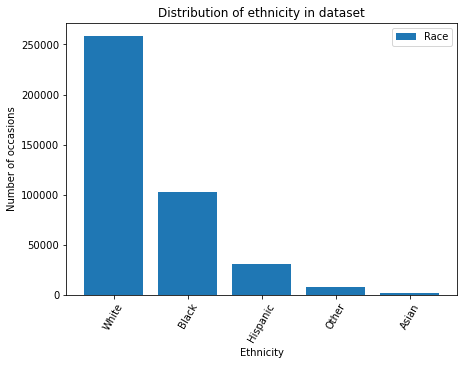

In [19]:
#representation of certain groups in the dataset
plt.figure(figsize=(7,5))
# Calculate the necessary number of bins for a better display
bins = np.arange(data['driver_race'].nunique()+1) - 0.5

plt.hist(data['driver_race'], bins=bins, rwidth=0.8, label='Race')
plt.xlabel('Ethnicity')
plt.ylabel('Number of occasions')
plt.title('Distribution of ethnicity in dataset')
plt.legend()
plt.xticks(rotation=60)
plt.show()

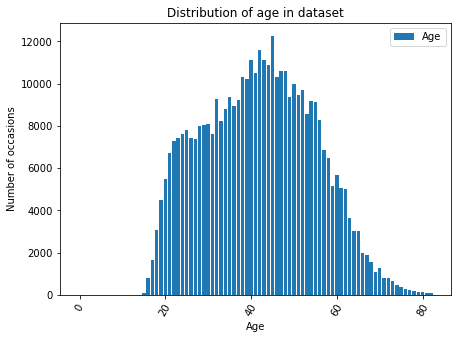

In [20]:
#representation of certain groups in the dataset
plt.figure(figsize=(7,5))
# Calculate the necessary number of bins for a better display
bins = np.arange(data['driver_age'].nunique()+1) - 0.5

plt.hist(data['driver_age'], bins=bins, rwidth=0.8, label='Age')
plt.xlabel('Age')
plt.ylabel('Number of occasions')
plt.title('Distribution of age in dataset')
plt.legend()
plt.xticks(rotation=60)
plt.show()

In [21]:
#number of arrestments among black and white people
data_race = data[['driver_race','stop_outcome']]
black_arr = data_race[data_race['driver_race']=='Black']
white_arr = data_race[data_race['driver_race']=='White']
hispanic_arr = data_race[data_race['driver_race']=='Hispanic']
asian_arr = data_race[data_race['driver_race']=='Asian']
other_arr = data_race[data_race['driver_race']=='Other']

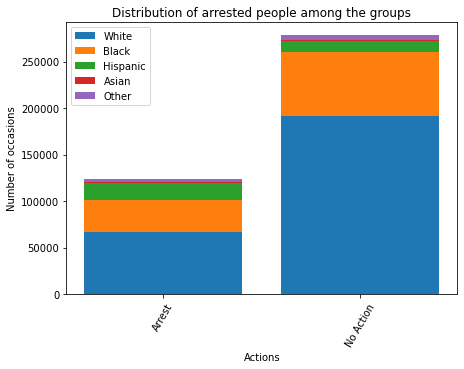

In [22]:
# Calculate the necessary number of bins for a better display
bins = np.arange(data_race['stop_outcome'].nunique()+1) - 0.5

plt.figure(figsize=(7,5))
# plt.hist([data_race['stop_outcome'], white_arr['stop_outcome'], black_arr['stop_outcome'], hispanic_arr['stop_outcome'], asian_arr['stop_outcome'], other_arr['stop_outcome']],
#          bins, label=['Overall','White','Black', 'Hispanic', 'Asian', 'Other'], rwidth=0.8, stacked=True)
plt.hist([white_arr['stop_outcome'], black_arr['stop_outcome'], hispanic_arr['stop_outcome'], asian_arr['stop_outcome'], other_arr['stop_outcome']],
         bins, label=['White','Black', 'Hispanic', 'Asian', 'Other'], rwidth=0.8, stacked=True)
plt.xlabel('Actions')
plt.ylabel('Number of occasions')
plt.title('Distribution of arrested people among the groups')
plt.legend(loc='upper left')
plt.xticks(rotation=60)
plt.show()

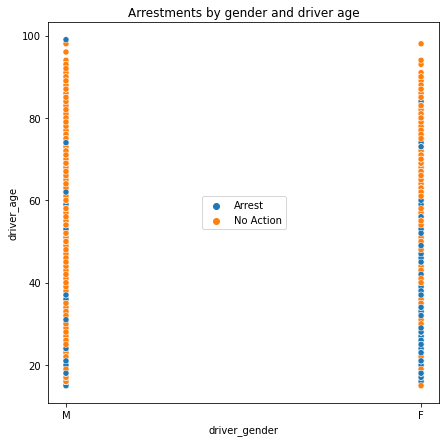

In [23]:
#scatter plot driver age against gender, frequency of arrestments
plt.figure(figsize=(7,7))
sns.scatterplot(x='driver_gender',y='driver_age',hue=data['stop_outcome'],data=data)
plt.legend(loc='center')
plt.title('Arrestments by gender and driver age')
plt.show()

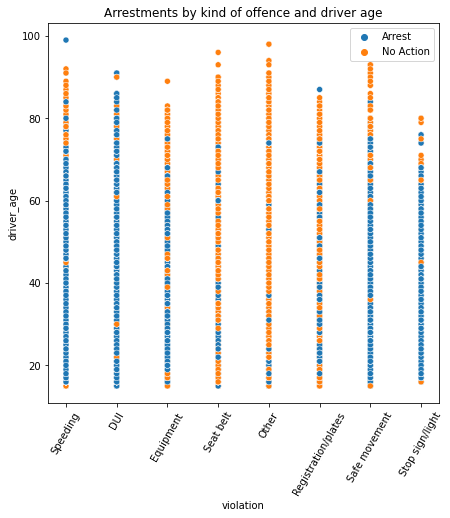

In [24]:
#scatter plot type of violation against driver age, frequency of arrestments
plt.figure(figsize=(7,7))
sns.scatterplot(x='violation',y='driver_age',hue=data['stop_outcome'],data=data)
plt.legend(loc='upper right')
plt.title('Arrestments by kind of offence and driver age')
plt.xticks(rotation=60)
plt.show()

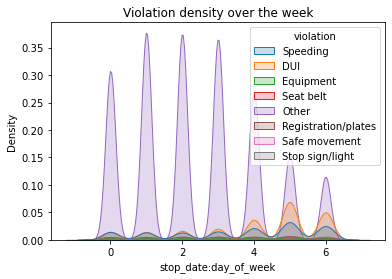

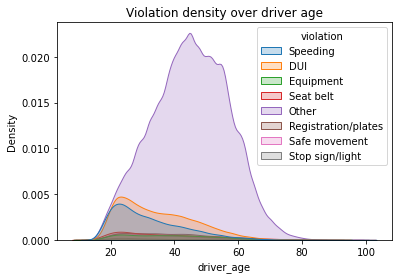

In [25]:
#kde to show on which day of the week does each type of
#violation occur the most
feat = data[['stop_date:day_of_week']]
for i,(column,color) in enumerate(zip(feat.columns,sns.color_palette())):
    plt.figure(i)
    sns.kdeplot(x=column,fill=True,hue=data.violation,data=data,color=color)
plt.title('Violation density over the week')
plt.show()
    
#kde to show the which type of violation mostly occurs
#by people of different ages
feat = data[['driver_age']]
for i,(column,color) in enumerate(zip(feat.columns,sns.color_palette())):
    plt.figure(i)
    sns.kdeplot(x=column,fill=True,hue=data.violation,data=data,color=color)
plt.title('Violation density over driver age')
plt.show()

# Classifiers

Two types of classifiers are implemented

- K-Nearest Neighbors
- Neural Network

## k-NN Classifier

### Finding the optimal k-value

Iterating over different k-values and testing the accuracy on the validation set

In [ ]:
# List to store the accuracy scores
pred_score_knn_train = []
pred_score_knn_val = []
# k-values to try out
k_range = range(1, 21)

print("Entering loop")
# Iterate over all the k-values in the list
for i in k_range:
    print(f'k={i}')

    print("Created class")

    # Create an instance of sped up KNN with n_neighbors=i
    knn = FaissKNeighbors(k=i)
    print("Created an instance of KNN")

    # Train the model on the training set with the encoded labels
    # The classifier only accepts contiguous arrays
    tmp_train = np.ascontiguousarray(X_train_norm.to_numpy())
    knn.fit(tmp_train, y_train)
    print("Fitting complete")
    y_pred_train = knn.predict(tmp_train)
    print("Training prediction complete")
    
    # The classifier only accepts contiguous arrays
    tmp_val = np.ascontiguousarray(X_val_norm.to_numpy())
    y_pred_val = knn.predict(tmp_val)
    print("Validation prediction complete")

    # Append the accuracy scores to the list
    pred_score_knn_train.append(accuracy_score(y_train, y_pred_train))
    pred_score_knn_val.append(accuracy_score(y_val, y_pred_val))
    print("Accuracy score calculated")

    print()

In [ ]:
# Save the accuracy scores
# pickle.dump(pred_score_knn_train, open('pickles/pred_score_knn_train.sav', 'wb'))
# pickle.dump(pred_score_knn_val, open('pickles/pred_score_knn_val.sav', 'wb'))

Plot the pre-computed result

In [ ]:
# Range of k-values for plotting purposes
k_range = range(1, 21)
# Load the pre-computed pred_score
pred_score_knn_train = pickle.load(open('pred_score_knn_train.sav', 'rb'))
pred_score_knn_val = pickle.load(open('pred_score_knn_val.sav', 'rb'))
# Convert the list to an array and multiply with 100 to get percentages
pred_score_knn_train = np.array(pred_score_knn_train) * 100
pred_score_knn_val = np.array(pred_score_knn_val) * 100
# Plot the results
plt.plot(k_range, pred_score_knn_train, label='Training prediction')
plt.plot(k_range, pred_score_knn_val, label='Validation prediction')
plt.xlabel("k values")
plt.ylabel("Accuracy")
plt.xticks(k_range)
plt.legend()
plt.grid()
plt.show()

### Measuring k-NN Classifier Performance

Pick k = 5 and train the standard classifier from scikit-learn 

#### Scikit-Learn

In [ ]:
# Create an instance of KNN with n_neighbors=5
knn_sklearn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
print("Created an instance of KNN")

In [ ]:
# Train the model on the training set with the encoded labels
knn_sklearn.fit(X_train_norm, y_train)
print("Fitting complete")

In [ ]:
#Predictions for training, validation and test set

y_pred_train_knn_sklearn = knn_sklearn.predict(X_train_norm)
print("Training prediction complete")

y_pred_val_knn_sklearn = knn_sklearn.predict(X_val_norm)
print("Validation prediction complete")

y_pred_test_knn_sklearn = knn_sklearn.predict(X_test_norm)
print("Test prediction complete")

In [ ]:
# Save the classifier and the variables to disk
# pickle.dump(knn_sklearn, open('pickles/knn_sklearn.sav', 'wb'))
# pickle.dump(y_pred_train_knn_sklearn, open('pickles/y_pred_train_knn_sklearn.sav', 'wb'))
# pickle.dump(y_pred_val_knn_sklearn, open('pickles/y_pred_val_knn_sklearn.sav', 'wb'))
# pickle.dump(y_pred_test_knn_sklearn, open('pickles/y_pred_test_knn_sklearn.sav', 'wb'))

Plotting the confusion matrices

In [ ]:
cm_train_knn_sklearn = confusion_matrix(y_train, y_pred_train_knn_sklearn)
cm_val_knn_sklearn = confusion_matrix(y_val, y_pred_val_knn_sklearn)
cm_test_knn_sklearn = confusion_matrix(y_test, y_pred_test_knn_sklearn)

tmp_dict = {'training': cm_train_knn_sklearn, 'validation': cm_val_knn_sklearn, 'test': cm_test_knn_sklearn}
plot_cm_subplots(tmp_dict, 'kNN classifier')

#### Faiss

The same thing for faiss

Fitting and prediction for k-NN from faiss

In [ ]:
knn_faiss = FaissKNeighbors(k=5) #not interpreted as classifier by plotting functions
print("Created an instance of KNN")

tmp_train = np.ascontiguousarray(X_train_norm.to_numpy())
knn_faiss.fit(tmp_train, y_train)
print("Fitting complete")

y_pred_train_knn_faiss = knn_faiss.predict(tmp_train)
print("Training prediction complete")

tmp_val = np.ascontiguousarray(X_val_norm.to_numpy())
y_pred_val_knn_faiss = knn_faiss.predict(tmp_val)
print("Validation prediction complete")

tmp_test = np.ascontiguousarray(X_test_norm.to_numpy())
y_pred_test_knn_faiss = knn_faiss.predict(tmp_test)
print("Test prediction complete")

In [ ]:
# Save the classifier and the variables to disk
# pickle.dump(knn_faiss, open('pickles/knn_faiss.sav', 'wb'))
# pickle.dump(y_pred_train_knn_faiss, open('pickles/y_pred_train_knn_faiss.sav', 'wb'))
# pickle.dump(y_pred_val_knn_faiss, open('pickles/y_pred_val_knn_faiss.sav', 'wb'))
# pickle.dump(y_pred_test_knn_faiss, open('pickles/y_pred_test_knn_faiss.sav', 'wb'))

Plotting the confusion matrices

In [ ]:
cm_train_knn_faiss = confusion_matrix(y_train, y_pred_train_knn_faiss)
cm_val_knn_faiss = confusion_matrix(y_val, y_pred_val_knn_faiss)
cm_test_knn_faiss = confusion_matrix(y_test, y_pred_test_knn_faiss)

tmp_dict = {'training': cm_train_knn_faiss, 'validation': cm_val_knn_faiss, 'test': cm_test_knn_faiss}
plot_cm_subplots(tmp_dict, 'kNN classifier with faiss')

### Dummy Classifier

In [ ]:
# Create an array with the length of y_test that always has the value 0 (Arrest)
y_train_dummy = np.zeros(len(y_train))
y_val_dummy = np.zeros(len(y_val))
y_test_dummy = np.zeros(len(y_test))

In [ ]:
#Measuring Accuracy Score

cm_train_dummy = confusion_matrix(y_train, y_train_dummy)
cm_val_dummy = confusion_matrix(y_test, y_val_dummy)
cm_test_dummy = confusion_matrix(y_test, y_test_dummy)

In [ ]:
tmp_dict = {'training': cm_train_dummy, 'validation': cm_val_dummy, 'test': cm_test_dummy} #plotting with function above
plot_cm_subplots(tmp_dict, 'kNN dummy classifier')

## Neural Network

### Finding the optimal number of hidden layers

In [ ]:
# List to store the accuracy scores
pred_score_nn_layers_train = []
pred_score_nn_layers_val = []
# k-values to try out
layers_range = range(21)

print("Entering loop")
# Iterate over all number of hidden layers in the list
for i in layers_range:
    print(f'k={i}')
    
    if i == 0:
        # Create an instance of NN with hidden_layer_sizes=(5,)
        nn_sklearn = MLPClassifier(solver='adam', alpha=1e-5,
                        hidden_layer_sizes=(5,), random_state=1, max_iter=1000)
        print("Created an instance of NN")
    else:
        # Create an instance of NN with hidden_layer_sizes=(5,)
        nn_sklearn = MLPClassifier(solver='adam', alpha=1e-5,
                        hidden_layer_sizes=(5,i), random_state=1, max_iter=1000)
        print("Created an instance of NN")
        
    # Train the model on the training set with the encoded labels
    nn_sklearn.fit(X_train_norm, y_train)
    print("Fitting complete")
    
    # Make predictions on the training set
    y_pred_train_nn_sklearn = nn_sklearn.predict(X_train_norm)
    print("Training prediction complete")
    
    # Make predictions on the validation set
    y_pred_val_nn_sklearn = nn_sklearn.predict(X_val_norm)
    print("Validation prediction complete")

    # Append the accuracy scores to the list
    pred_score_nn_layers_train.append(accuracy_score(y_train, y_pred_train_nn_sklearn))
    print("Training accuracy score calculated")
    pred_score_nn_layers_val.append(accuracy_score(y_val, y_pred_val_nn_sklearn))
    print("Validation accuracy score calculated")

    print()

In [ ]:
# Save the accuracy scores
#pickle.dump(pred_score_nn_layers_train, open('pickles/pred_score_nn_layers_train.sav', 'wb'))
#pickle.dump(pred_score_nn_layers_val, open('pickles/pred_score_nn_layers_val.sav', 'wb'))

In [ ]:
# Range of k-values for plotting purposes
layers_range = range(21)
# Load the pre-computed pred_score
pred_score_nn_layers_train = pickle.load(open('pickles/pred_score_nn_layers_train.sav', 'rb'))
pred_score_nn_layers_val = pickle.load(open('pickles/pred_score_nn_layers_val.sav', 'rb'))
# Convert the list to an array and multiply with 100 to get percentages
pred_score_nn_layers_train = np.array(pred_score_nn_layers_train) * 100
pred_score_nn_layers_val = np.array(pred_score_nn_layers_val) * 100
# Plot the results
plt.plot(layers_range, pred_score_nn_layers_train, label='Training accuracy')
plt.plot(layers_range, pred_score_nn_layers_val, label='Validation accuracy')
plt.xlabel("Number of hidden layers")
plt.ylabel("Accuracy")
plt.xticks(layers_range)
plt.legend()
plt.grid()
plt.show()

### Finding the optimal number of hidden units

In [ ]:
np.arange(5, 105, 5)

In [ ]:
# List to store the accuracy scores
pred_score_nn_train = []
pred_score_nn_val = []
# Number of hidden units to try out
num_hids_range = np.arange(5, 105, 5)

print("Entering loop")
# Iterate over all numbers of hidden units in the list
for i in num_hids_range:
    print(f'k={i}')

    # Create an instance of NN with hidden_layer_sizes=(i,)
    nn_sklearn = MLPClassifier(solver='adam', alpha=1e-5,
                    hidden_layer_sizes=(i,8), random_state=1, max_iter=1000)
    print("Created an instance of NN")

    # Train the model on the training set with the encoded labels
    nn_sklearn.fit(X_train_norm, y_train)
    print("Fitting complete")
    
    # Make predictions on the training set
    y_pred_train_nn_sklearn = nn_sklearn.predict(X_train_norm)
    print("Training prediction complete")
    
    # Make predictions on the validation set
    y_pred_val_nn_sklearn = nn_sklearn.predict(X_val_norm)
    print("Validation prediction complete")

    # Append the accuracy scores to the list
    pred_score_nn_train.append(accuracy_score(y_train, y_pred_train_nn_sklearn))
    print("Training accuracy score calculated")
    pred_score_nn_val.append(accuracy_score(y_val, y_pred_val_nn_sklearn))
    print("Validation accuracy score calculated")

    print()

In [ ]:
# Save the accuracy scores
# pickle.dump(pred_score_nn_train, open('pickles/pred_score_nn_train_8.sav', 'wb'))
# pickle.dump(pred_score_nn_val, open('pickles/pred_score_nn_val_8.sav', 'wb'))

In [ ]:
# Range of k-values for plotting purposes
num_hids_range = np.arange(5, 105, 5)
# Load the pre-computed pred_score
pred_score_nn_train_8 = pickle.load(open('pickles/pred_score_nn_train_8.sav', 'rb'))
pred_score_nn_val_8 = pickle.load(open('pickles/pred_score_nn_val_8.sav', 'rb'))
# Convert the list to an array and multiply with 100 to get percentages
pred_score_nn_train_8 = np.array(pred_score_nn_train_8) * 100
pred_score_nn_val_8 = np.array(pred_score_nn_val_8) * 100
# Plot the results
plt.plot(num_hids_range, pred_score_nn_train_8, label='Training accuracy')
plt.plot(num_hids_range, pred_score_nn_val_8, label='Validation accuracy')
plt.xlabel("Number of hidden units")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Save the accuracy scores
# pickle.dump(pred_score_nn_train, open('pickles/pred_score_nn_train.sav', 'wb'))
# pickle.dump(pred_score_nn_val, open('pickles/pred_score_nn_val.sav', 'wb'))

In [ ]:
# Range of k-values for plotting purposes
num_hids_range = np.arange(5, 205, 5)
# Load the pre-computed pred_score
pred_score_nn_train = pickle.load(open('pickles/pred_score_nn_train.sav', 'rb'))
pred_score_nn_val = pickle.load(open('pickles/pred_score_nn_val.sav', 'rb'))
# Convert the list to an array and multiply with 100 to get percentages
pred_score_nn_train = np.array(pred_score_nn_train) * 100
pred_score_nn_val = np.array(pred_score_nn_val) * 100
# Plot the results
plt.plot(num_hids_range, pred_score_nn_train, label='Training accuracy')
plt.plot(num_hids_range, pred_score_nn_val, label='Validation accuracy')
plt.xlabel("Number of hidden units")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

### Measuring NN performance


In [ ]:
# Create an instance of NN with hidden_layer_sizes=(20,)
nn_sklearn = MLPClassifier(solver='adam', alpha=1e-5,
                hidden_layer_sizes=(40,8), random_state=1, max_iter=1000)
print("Created an instance of NN")

# Train the model on the training set with the encoded labels
nn_sklearn.fit(X_train_norm, y_train)
print("Fitting complete")

# Make predictions on the training set
y_pred_train_nn_sklearn = nn_sklearn.predict(X_train_norm)
print("Training prediction complete")

# Make predictions on the validation set
y_pred_val_nn_sklearn = nn_sklearn.predict(X_val_norm)
print("Validation prediction complete")

# Make predictions on the test set
y_pred_test_nn_sklearn = nn_sklearn.predict(X_test_norm)
print("Test prediction complete")

Plotting the confusion matrices

In [ ]:
# Save the classifier to disk
# pickle.dump(nn_sklearn, open('pickles/nn_sklearn.sav', 'wb'))
# pickle.dump(y_pred_train_nn_sklearn, open('pickles/y_pred_train_nn_sklearn.sav', 'wb'))
# pickle.dump(y_pred_val_nn_sklearn, open('pickles/y_pred_val_nn_sklearn.sav', 'wb'))
# pickle.dump(y_pred_test_nn_sklearn, open('pickles/y_pred_test_nn_sklearn.sav', 'wb'))

In [ ]:
# Load the pre-computed results
cm_train_nn_sklearn = confusion_matrix(y_train, y_pred_train_nn_sklearn)
cm_val_nn_sklearn = confusion_matrix(y_val, y_pred_val_nn_sklearn)
cm_test_nn_sklearn = confusion_matrix(y_test, y_pred_test_nn_sklearn)

tmp_dict = {'training': cm_train_nn_sklearn, 'validation': cm_val_nn_sklearn, 'test': cm_test_nn_sklearn}
plot_cm_subplots(tmp_dict, 'Neural Network with one hidden layer and 20 hidden units')

Metrics for accuracy of the model and plotting the confusion matrices for training, validation and test set

In [ ]:
print("Accuracy on training set: %f" %accuracy_score(y_train, y_pred_train_nn_sklearn))
print("Accuracy on validation set: %f" %accuracy_score(y_val, y_pred_val_nn_sklearn))
print("Accuracy on test set: %f" %accuracy_score(y_test, y_pred_test_nn_sklearn))

# Learning curves

In [ ]:
train_sizes_knn, train_scores_knn, test_scores_knn, fit_times_knn, _ = \
    learning_curve(knn_sklearn, X_train_norm, y_train, n_jobs=-1,
                   return_times=True)

In [ ]:
# pickle.dump(train_sizes_knn, open('pickles/train_sizes_knn.sav', 'wb'))
# pickle.dump(train_scores_knn, open('pickles/train_scores_knn.sav', 'wb'))
# pickle.dump(test_scores_knn, open('pickles/test_scores_knn.sav', 'wb'))
# pickle.dump(fit_times_knn, open('pickles/fit_times_knn.sav', 'wb'))

In [ ]:
train_scores_mean_knn = np.mean(train_scores_knn, axis=1)
train_scores_std_knn = np.std(train_scores_knn, axis=1)
test_scores_mean_knn = np.mean(test_scores_knn, axis=1)
test_scores_std_knn = np.std(test_scores_knn, axis=1)
fit_times_mean_knn = np.mean(fit_times_knn, axis=1)
fit_times_std_knn = np.std(fit_times_knn, axis=1)

# Plot learning curve
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0,0,1,1])

plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()
plt.xlim()
plt.fill_between(train_sizes_knn, train_scores_mean_knn - train_scores_std_knn,
                     train_scores_mean_knn + train_scores_std_knn, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes_knn, test_scores_mean_knn - test_scores_std_knn,
                     test_scores_mean_knn + test_scores_std_knn, alpha=0.1,
                     color="g")
plt.plot(train_sizes_knn, train_scores_mean_knn, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes_knn, test_scores_mean_knn, 'o-', color="g",
             label="Cross-validation score")
plt.legend(loc="best")
plt.show()

In [ ]:
train_sizes_nn, train_scores_nn, test_scores_nn, fit_times_nn, _ = \
    learning_curve(nn_sklearn, X_train_norm, y_train, n_jobs=-1,
                   return_times=True)

In [ ]:
# pickle.dump(train_sizes_nn, open('pickles/train_sizes_nn.sav', 'wb'))
# pickle.dump(train_scores_nn, open('pickles/train_scores_nn.sav', 'wb'))
# pickle.dump(test_scores_nn, open('pickles/test_scores_nn.sav', 'wb'))
# pickle.dump(fit_times_nn, open('pickles/fit_times_nn.sav', 'wb'))

In [ ]:
train_scores_mean_nn = np.mean(train_scores_nn, axis=1)
train_scores_std_nn = np.std(train_scores_nn, axis=1)
test_scores_mean_nn = np.mean(test_scores_nn, axis=1)
test_scores_std_nn = np.std(test_scores_nn, axis=1)
fit_times_mean_nn = np.mean(fit_times_nn, axis=1)
fit_times_std_nn = np.std(fit_times_nn, axis=1)

# Plot learning curve
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0,0,1,1])

plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()
plt.xlim()
plt.fill_between(train_sizes_nn, train_scores_mean_nn - train_scores_std_nn,
                     train_scores_mean_nn + train_scores_std_nn, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes_nn, test_scores_mean_nn - test_scores_std_nn,
                     test_scores_mean_nn + test_scores_std_nn, alpha=0.1,
                     color="g")
plt.plot(train_sizes_nn, train_scores_mean_nn, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes_nn, test_scores_mean_nn, 'o-', color="g",
             label="Cross-validation score")
plt.legend(loc="best")
plt.show()

### Fairness Metrics: Independence, Seperation and Sufficiency

To check the fairness of the model, we measure the independence, separation and sufficiency.

- Independence: sensitive features are statistically independent to the outcome of the prediction. 

- Separation: Given the target variable, sensitive features are statistically independent to the outcome of the prediction.

- Sufficiency: Given the outcome of the prediction, sensitive features are statistically independent to the target variable.

In [26]:
def independence(tn, fp, fn, tp):
    # change the calculation of output
    output = (tp + fp) / (tn + fp + fn + tp)
    return output

In [27]:
def separation(tn, fp, fn, tp):
    # change the calculation of the seperation for the two conditions Y_1 and Y_0
    Y_1 = tp / (tp + fp)
    Y_0 = tn / (tn + fn)
    return Y_1, Y_0

In [28]:
def sufficiency(tn, fp, fn, tp):
    # change the calculation of the seperation for the two conditions R_1 and R_0
    R_1 = tp / (tp + fn)
    R_0 = fp / (fp + tn)
    return R_1, R_0

#### Race groups

Measuring the fairnes metrics for different race groups

In [29]:
# Choose which classifier to use
# y_pred = y_pred_nn_sklearn # neural network sklearn
# y_pred = y_pred_knn_faiss # faiss knn
y_pred = y_pred_test_knn_sklearn # knn sklearn

In [30]:
group_asian = X_test['driver_race_Asian'] == 1
group_black = X_test['driver_race_Black'] == 1
group_white = X_test['driver_race_White'] == 1
group_hispanic = X_test['driver_race_Hispanic'] == 1
group_other = X_test['driver_race_Other'] == 1

y_pred_asian = y_pred[group_asian]
y_test_asian = y_test[group_asian]
X_test_asian = X_test[group_asian]

y_pred_black = y_pred[group_black]
y_test_black = y_test[group_black]
X_test_black = X_test[group_black]

y_pred_white = y_pred[group_white]
y_test_white = y_test[group_white]
X_test_white = X_test[group_white]

y_pred_hispanic = y_pred[group_hispanic]
y_test_hispanic = y_test[group_hispanic]
X_test_hispanic = X_test[group_hispanic]

y_pred_other = y_pred[group_other]
y_test_other = y_test[group_other]
X_test_other = X_test[group_other]

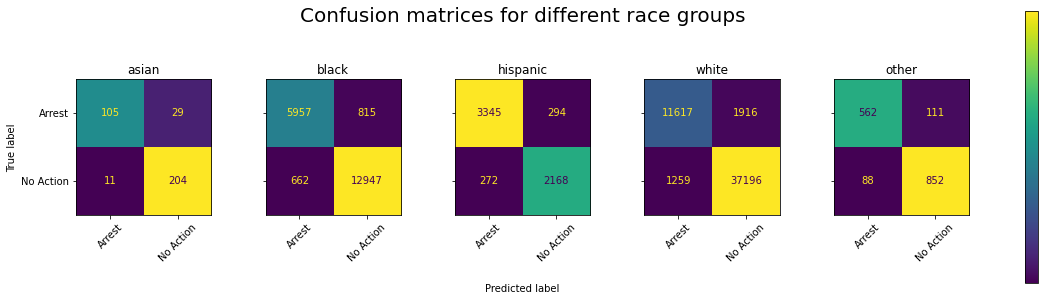

In [31]:
cm_asian = confusion_matrix(y_test_asian, y_pred_asian)
cm_black = confusion_matrix(y_test_black, y_pred_black)
cm_white = confusion_matrix(y_test_white, y_pred_white)
cm_hispanic = confusion_matrix(y_test_hispanic, y_pred_hispanic)
cm_other = confusion_matrix(y_test_other, y_pred_other)

tmp_dict = {'asian': cm_asian, 'black': cm_black, 'hispanic': cm_hispanic, 'white': cm_white, 'other': cm_other}
plot_cm_subplots(tmp_dict, 'Confusion matrices for different race groups', 0.1, 0.85, '')

In [32]:
tn_asian, fp_asian, fn_asian, tp_asian = confusion_matrix(y_test_asian, y_pred_asian).ravel()
tn_black, fp_black, fn_black, tp_black = confusion_matrix(y_test_black, y_pred_black).ravel()
tn_white, fp_white, fn_white, tp_white = confusion_matrix(y_test_white, y_pred_white).ravel()
tn_hispanic, fp_hispanic, fn_hispanic, tp_hispanic = confusion_matrix(y_test_hispanic, y_pred_hispanic).ravel()
tn_other, fp_other, fn_other, tp_other = confusion_matrix(y_test_other, y_pred_other).ravel()

##### Independence for race groups

In [33]:
ind_asian = independence(tn_asian, fp_asian, fn_asian, tp_asian)
ind_black = independence(tn_black, fp_black, fn_black, tp_black)
ind_white = independence(tn_white, fp_white, fn_white, tp_white)
ind_hispanic = independence(tn_hispanic, fp_hispanic, fn_hispanic, tp_hispanic)
ind_other = independence(tn_other, fp_other, fn_other, tp_other)

In [34]:
print(ind_asian, ind_black, ind_white, ind_hispanic, ind_other)

0.667621776504298 0.6752367401010745 0.7523274601831191 0.4050008225037013 0.597024178549287


##### Separation for race groups

In [35]:
sep_asian = separation(tn_asian, fp_asian, fn_asian, tp_asian)
sep_black = separation(tn_black, fp_black, fn_black, tp_black)
sep_white = separation(tn_white, fp_white, fn_white, tp_white)
sep_hispanic = separation(tn_hispanic, fp_hispanic, fn_hispanic, tp_hispanic)
sep_other = separation(tn_other, fp_other, fn_other, tp_other)

In [36]:
print(sep_asian, sep_black, sep_white, sep_hispanic, sep_other)

(0.8755364806866953, 0.9051724137931034) (0.9407789565470135, 0.8999848919776401) (0.9510124769891594, 0.9022211867039454) (0.8805848903330625, 0.9247995576444568) (0.8847352024922118, 0.8646153846153846)


##### Sufficiency for race groups

In [37]:
suf_asian = sufficiency(tn_asian, fp_asian, fn_asian, tp_asian)
suf_black = sufficiency(tn_black, fp_black, fn_black, tp_black)
suf_white = sufficiency(tn_white, fp_white, fn_white, tp_white)
suf_hispanic = sufficiency(tn_hispanic, fp_hispanic, fn_hispanic, tp_hispanic)
suf_other = sufficiency(tn_other, fp_other, fn_other, tp_other)

In [38]:
print(suf_asian, suf_black, suf_white, suf_hispanic, suf_other)

(0.9488372093023256, 0.21641791044776118) (0.9513557204790947, 0.12034849379799173) (0.9672604342738266, 0.1415798418680263) (0.8885245901639345, 0.0807914262159934) (0.9063829787234042, 0.1649331352154532)


#### Age groups

Measuring the fairnes metrics for different age groups

In [39]:
# Reference: https://www.sciencedirect.com/science/article/pii/S0386111214600315#:~:text=Three%20driver%20age%20groups%20(old,aged%20less%20than%2030%20years.
group_young = X_test['driver_age'] < 30
group_middle = (X_test['driver_age'] >= 30) & (X_test['driver_age'] < 65)
group_elderly = X_test['driver_age'] >= 65

In [40]:
y_pred_young = y_pred[group_young]
y_test_young = y_test[group_young]
X_test_young = X_test[group_young]

y_pred_middle = y_pred[group_middle]
y_test_middle = y_test[group_middle]
X_test_middle = X_test[group_middle]

y_pred_elderly = y_pred[group_elderly]
y_test_elderly = y_test[group_elderly]
X_test_elderly = X_test[group_elderly]

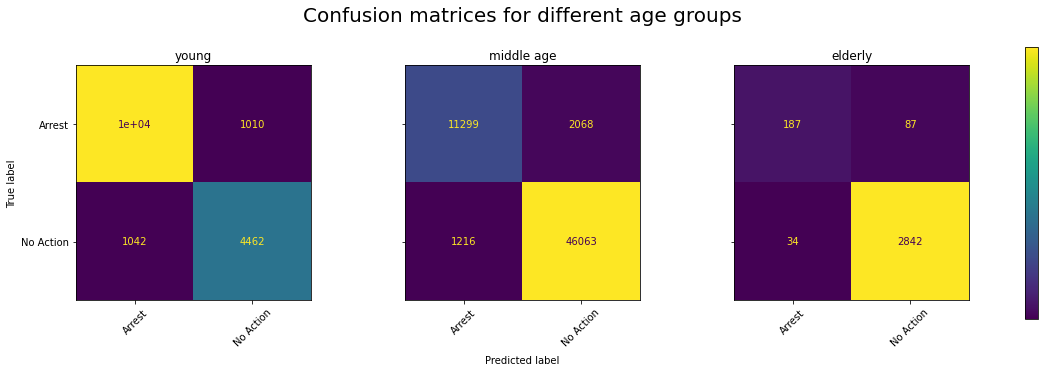

In [41]:
cm_young = confusion_matrix(y_test_young, y_pred_young)
cm_middle = confusion_matrix(y_test_middle, y_pred_middle)
cm_elderly = confusion_matrix(y_test_elderly, y_pred_elderly)

tmp_dict = {'young': cm_young, 'middle age': cm_middle, 'elderly': cm_elderly}
plot_cm_subplots(tmp_dict, 'Confusion matrices for different age groups', 0, 0.95, '')

In [42]:
tn_young, fp_young, fn_young, tp_young = confusion_matrix(y_test_young, y_pred_young).ravel()
tn_middle, fp_middle, fn_middle, tp_middle = confusion_matrix(y_test_middle, y_pred_middle).ravel()
tn_elderly, fp_elderly, fn_elderly, tp_elderly = confusion_matrix(y_test_elderly, y_pred_elderly).ravel()

##### Independence for age groups

In [43]:
ind_young = independence(tn_young, fp_young, fn_young, tp_young)
ind_middle = independence(tn_middle, fp_middle, fn_middle, tp_middle)
ind_elderly = independence(tn_elderly, fp_elderly, fn_elderly, tp_elderly)

In [44]:
print(ind_young, ind_middle, ind_elderly)

0.3293607800650054 0.793638492233618 0.9298412698412698


##### Separation for age groups

In [45]:
sep_young = separation(tn_young, fp_young, fn_young, tp_young)
sep_middle = separation(tn_middle, fp_middle, fn_middle, tp_middle)
sep_elderly = separation(tn_elderly, fp_elderly, fn_elderly, tp_elderly)

In [46]:
print(sep_young, sep_middle, sep_elderly)

(0.8154239766081871, 0.906479985639921) (0.9570339282375184, 0.9028365960846984) (0.9702970297029703, 0.8461538461538461)


##### Sufficiency for age groups

In [47]:
suf_young = sufficiency(tn_young, fp_young, fn_young, tp_young)
suf_middle = sufficiency(tn_middle, fp_middle, fn_middle, tp_middle)
suf_elderly = sufficiency(tn_elderly, fp_elderly, fn_elderly, tp_elderly)

In [48]:
print(suf_young, suf_middle, suf_elderly)

(0.8106831395348837, 0.09090909090909091) (0.9742803358785084, 0.15470935886885614) (0.9881780250347705, 0.3175182481751825)


#### Gender

Measuring the fairnes metrics for different gender groups

In [49]:
group_female = X_test['driver_gender'] == 0
group_male = X_test['driver_gender'] == 1

In [50]:
y_pred_female = y_pred[group_female]
y_test_female = y_test[group_female]
X_test_female = X_test[group_female]

y_pred_male = y_pred[group_male]
y_test_male = y_test[group_male]
X_test_male = X_test[group_male]

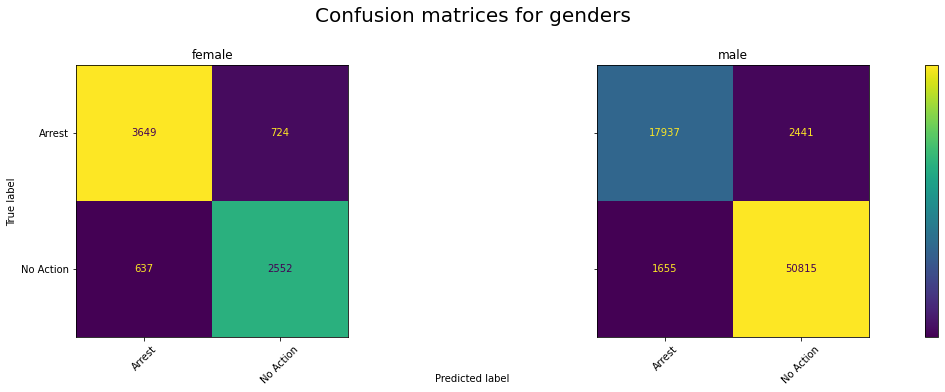

In [51]:
cm_female = confusion_matrix(y_test_female, y_pred_female)
cm_male = confusion_matrix(y_test_male, y_pred_male)

tmp_dict = {'female': cm_female, 'male': cm_male}
plot_cm_subplots(tmp_dict, 'Confusion matrices for genders', 0, 1, '')

In [52]:
tn_female, fp_female, fn_female, tp_female = confusion_matrix(y_test_female, y_pred_female).ravel()
tn_male, fp_male, fn_male, tp_male = confusion_matrix(y_test_male, y_pred_male).ravel()

##### Independence for gender groups

In [53]:
ind_female = independence(tn_female, fp_female, fn_female, tp_female)
ind_male = independence(tn_male, fp_male, fn_male, tp_male)

In [54]:
print(ind_female, ind_male) 

0.43321872520497223 0.7310564462991435


##### Separation for gender groups

In [55]:
sep_female = separation(tn_female, fp_female, fn_female, tp_female)
sep_male = separation(tn_male, fp_male, fn_male, tp_male)

In [56]:
print(sep_female, sep_male)

(0.778998778998779, 0.851376574895007) (0.9541647889439687, 0.9155267456104532)


##### Sufficiency for gender groups

In [57]:
suf_female = sufficiency(tn_female, fp_female, fn_female, tp_female)
suf_male = sufficiency(tn_male, fp_male, fn_male, tp_male)

In [58]:
print(suf_female, suf_male)

(0.8002508623392913, 0.16556139949691287) (0.9684581665713741, 0.11978604377269604)


# Fairness through unawareness

Leaving out sensitive features before fitting the model

## Creating new matrices

In [59]:
X_train_norm

,driver_gender,driver_age,violation,search_type,contraband_found,search_basis,officer_id,drugs_related_stop,district,stop_date:day_of_week,driver_race_Asian,driver_race_Black,driver_race_Hispanic,driver_race_Other,driver_race_White
376090,0.323003,0.315311,-0.170781,0.180831,-0.130247,0.088705,0.049197,-0.104827,0.079392,0.641341,-0.066466,-0.587797,-0.287442,-0.144067,0.746479
381498,0.323003,-0.222630,-0.170781,0.180831,-0.130247,0.088705,0.165899,-0.104827,0.807083,0.110470,-0.066466,-0.587797,-0.287442,-0.144067,0.746479
155966,0.323003,-0.991118,-0.170781,0.180831,-0.130247,0.088705,1.038166,-0.104827,0.503878,-0.420400,-0.066466,-0.587797,-0.287442,-0.144067,0.746479
148275,0.323003,-1.067967,-0.170781,0.180831,-0.130247,0.088705,-0.847009,-0.104827,0.140033,-0.420400,-0.066466,1.701267,-0.287442,-0.144067,-1.339623
344347,0.323003,-0.606874,-0.170781,0.180831,-0.130247,0.088705,0.613253,-0.104827,0.564519,1.703081,-0.066466,-0.587797,-0.287442,-0.144067,0.746479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340621,0.323003,-0.068933,-0.170781,0.180831,-0.130247,0.088705,0.435209,-0.104827,0.807083,-0.420400,-0.066466,-0.587797,-0.287442,-0.144067,0.746479
106869,0.323003,-0.299479,-0.170781,0.180831,-0.130247,0.088705,0.786809,-0.104827,-0.284453,-1.482141,-0.066466,-0.587797,3.478958,-0.144067,-1.339623
92828,0.323003,-0.530026,-0.170781,0.180831,-0.130247,0.088705,-1.316806,-0.104827,0.867724,-0.951271,-0.066466,-0.587797,-0.287442,-0.144067,0.746479
37632,0.323003,-1.144816,-0.170781,0.180831,-0.130247,0.088705,1.005250,-0.104827,1.110287,-0.951271,-0.066466,-0.587797,-0.287442,-0.144067,0.746479


### New X matrices where the race groups are dropped (model is unaware of subject's race)

In [60]:
#dropping race from training test and validation set:

X_train_norace = X_train_norm.drop (columns=["driver_race_Asian","driver_race_Black","driver_race_Hispanic","driver_race_Other",
                                             "driver_race_White" ])
X_test_norace = X_test_norm.drop(columns=["driver_race_Asian","driver_race_Black","driver_race_Hispanic","driver_race_Other",
                                             "driver_race_White" ]) 
X_val_norace = X_val_norm.drop(columns=["driver_race_Asian","driver_race_Black","driver_race_Hispanic","driver_race_Other",
                                             "driver_race_White" ]) 

In [61]:
X_train_norace

,driver_gender,driver_age,violation,search_type,contraband_found,search_basis,officer_id,drugs_related_stop,district,stop_date:day_of_week
376090,0.323003,0.315311,-0.170781,0.180831,-0.130247,0.088705,0.049197,-0.104827,0.079392,0.641341
381498,0.323003,-0.222630,-0.170781,0.180831,-0.130247,0.088705,0.165899,-0.104827,0.807083,0.110470
155966,0.323003,-0.991118,-0.170781,0.180831,-0.130247,0.088705,1.038166,-0.104827,0.503878,-0.420400
148275,0.323003,-1.067967,-0.170781,0.180831,-0.130247,0.088705,-0.847009,-0.104827,0.140033,-0.420400
344347,0.323003,-0.606874,-0.170781,0.180831,-0.130247,0.088705,0.613253,-0.104827,0.564519,1.703081
...,...,...,...,...,...,...,...,...,...,...
340621,0.323003,-0.068933,-0.170781,0.180831,-0.130247,0.088705,0.435209,-0.104827,0.807083,-0.420400
106869,0.323003,-0.299479,-0.170781,0.180831,-0.130247,0.088705,0.786809,-0.104827,-0.284453,-1.482141
92828,0.323003,-0.530026,-0.170781,0.180831,-0.130247,0.088705,-1.316806,-0.104827,0.867724,-0.951271
37632,0.323003,-1.144816,-0.170781,0.180831,-0.130247,0.088705,1.005250,-0.104827,1.110287,-0.951271


### New X matrices where the gender groups are dropped (model is unaware of subject's gender)

In [62]:
#dropping gender
X_train_nogender = X_train_norm.drop (columns=["driver_gender" ])
X_test_nogender= X_test_norm.drop(columns=["driver_gender" ])
X_val_nogender= X_val_norm.drop(columns=["driver_gender" ])

In [63]:
X_train_nogender

,driver_age,violation,search_type,contraband_found,search_basis,officer_id,drugs_related_stop,district,stop_date:day_of_week,driver_race_Asian,driver_race_Black,driver_race_Hispanic,driver_race_Other,driver_race_White
376090,0.315311,-0.170781,0.180831,-0.130247,0.088705,0.049197,-0.104827,0.079392,0.641341,-0.066466,-0.587797,-0.287442,-0.144067,0.746479
381498,-0.222630,-0.170781,0.180831,-0.130247,0.088705,0.165899,-0.104827,0.807083,0.110470,-0.066466,-0.587797,-0.287442,-0.144067,0.746479
155966,-0.991118,-0.170781,0.180831,-0.130247,0.088705,1.038166,-0.104827,0.503878,-0.420400,-0.066466,-0.587797,-0.287442,-0.144067,0.746479
148275,-1.067967,-0.170781,0.180831,-0.130247,0.088705,-0.847009,-0.104827,0.140033,-0.420400,-0.066466,1.701267,-0.287442,-0.144067,-1.339623
344347,-0.606874,-0.170781,0.180831,-0.130247,0.088705,0.613253,-0.104827,0.564519,1.703081,-0.066466,-0.587797,-0.287442,-0.144067,0.746479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340621,-0.068933,-0.170781,0.180831,-0.130247,0.088705,0.435209,-0.104827,0.807083,-0.420400,-0.066466,-0.587797,-0.287442,-0.144067,0.746479
106869,-0.299479,-0.170781,0.180831,-0.130247,0.088705,0.786809,-0.104827,-0.284453,-1.482141,-0.066466,-0.587797,3.478958,-0.144067,-1.339623
92828,-0.530026,-0.170781,0.180831,-0.130247,0.088705,-1.316806,-0.104827,0.867724,-0.951271,-0.066466,-0.587797,-0.287442,-0.144067,0.746479
37632,-1.144816,-0.170781,0.180831,-0.130247,0.088705,1.005250,-0.104827,1.110287,-0.951271,-0.066466,-0.587797,-0.287442,-0.144067,0.746479


### New X matrices where the age groups are dropped (model is unaware of subject's age)

In [64]:
#dropping age
X_train_noage = X_train_norm.drop (columns=["driver_age" ])
X_test_noage= X_test_norm.drop(columns=["driver_age" ])
X_val_noage= X_val_norm.drop(columns=["driver_age" ])

In [65]:
X_train_noage

,driver_gender,violation,search_type,contraband_found,search_basis,officer_id,drugs_related_stop,district,stop_date:day_of_week,driver_race_Asian,driver_race_Black,driver_race_Hispanic,driver_race_Other,driver_race_White
376090,0.323003,-0.170781,0.180831,-0.130247,0.088705,0.049197,-0.104827,0.079392,0.641341,-0.066466,-0.587797,-0.287442,-0.144067,0.746479
381498,0.323003,-0.170781,0.180831,-0.130247,0.088705,0.165899,-0.104827,0.807083,0.110470,-0.066466,-0.587797,-0.287442,-0.144067,0.746479
155966,0.323003,-0.170781,0.180831,-0.130247,0.088705,1.038166,-0.104827,0.503878,-0.420400,-0.066466,-0.587797,-0.287442,-0.144067,0.746479
148275,0.323003,-0.170781,0.180831,-0.130247,0.088705,-0.847009,-0.104827,0.140033,-0.420400,-0.066466,1.701267,-0.287442,-0.144067,-1.339623
344347,0.323003,-0.170781,0.180831,-0.130247,0.088705,0.613253,-0.104827,0.564519,1.703081,-0.066466,-0.587797,-0.287442,-0.144067,0.746479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340621,0.323003,-0.170781,0.180831,-0.130247,0.088705,0.435209,-0.104827,0.807083,-0.420400,-0.066466,-0.587797,-0.287442,-0.144067,0.746479
106869,0.323003,-0.170781,0.180831,-0.130247,0.088705,0.786809,-0.104827,-0.284453,-1.482141,-0.066466,-0.587797,3.478958,-0.144067,-1.339623
92828,0.323003,-0.170781,0.180831,-0.130247,0.088705,-1.316806,-0.104827,0.867724,-0.951271,-0.066466,-0.587797,-0.287442,-0.144067,0.746479
37632,0.323003,-0.170781,0.180831,-0.130247,0.088705,1.005250,-0.104827,1.110287,-0.951271,-0.066466,-0.587797,-0.287442,-0.144067,0.746479


### New X matrices where all sensitive features are dropped (model is unaware of subject's race, gender and age)

In [66]:
X_train_unaw = X_train_norm.drop (columns=["driver_race_Asian","driver_race_Black","driver_race_Hispanic","driver_race_Other",
                                             "driver_race_White", "driver_gender","driver_age" ])
X_test_unaw = X_test_norm.drop(columns=["driver_race_Asian","driver_race_Black","driver_race_Hispanic","driver_race_Other",
                                             "driver_race_White", "driver_gender", "driver_age" ]) 
X_val_unaw = X_val_norm.drop(columns=["driver_race_Asian","driver_race_Black","driver_race_Hispanic","driver_race_Other",
                                             "driver_race_White", "driver_gender", "driver_age" ]) 

In [67]:
X_train_unaw

,violation,search_type,contraband_found,search_basis,officer_id,drugs_related_stop,district,stop_date:day_of_week
376090,-0.170781,0.180831,-0.130247,0.088705,0.049197,-0.104827,0.079392,0.641341
381498,-0.170781,0.180831,-0.130247,0.088705,0.165899,-0.104827,0.807083,0.110470
155966,-0.170781,0.180831,-0.130247,0.088705,1.038166,-0.104827,0.503878,-0.420400
148275,-0.170781,0.180831,-0.130247,0.088705,-0.847009,-0.104827,0.140033,-0.420400
344347,-0.170781,0.180831,-0.130247,0.088705,0.613253,-0.104827,0.564519,1.703081
...,...,...,...,...,...,...,...,...
340621,-0.170781,0.180831,-0.130247,0.088705,0.435209,-0.104827,0.807083,-0.420400
106869,-0.170781,0.180831,-0.130247,0.088705,0.786809,-0.104827,-0.284453,-1.482141
92828,-0.170781,0.180831,-0.130247,0.088705,-1.316806,-0.104827,0.867724,-0.951271
37632,-0.170781,0.180831,-0.130247,0.088705,1.005250,-0.104827,1.110287,-0.951271


## Model fitting using the new matrices

### Without race

In [ ]:
# Create an instance of KNN with n_neighbors=5 
knn_norace = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
print("Created an instance of KNN")

# Train the model on the training set with the encoded labels
knn_norace.fit(X_train_norace, y_train)
print("Fitting complete")

#predictions for training, validation and test set:
y_pred_train_norace = knn_norace.predict(X_train_norace)
print("Training prediction complete")
y_pred_val_norace = knn_norace.predict(X_val_norace)
print("Validation prediction complete")
y_pred_test_norace = knn_norace.predict(X_test_norace)
print("Test prediction complete")

pred_score_knn_norace = accuracy_score(y_test, y_pred_test_norace)
print("Accuracy score calculated")

In [ ]:
print(pred_score_knn_norace) #the accuracy score is high

In [ ]:
# Save the classifier and the variables to disk
# pickle.dump(knn_norace, open('pickles/knn_norace.sav', 'wb'))
# pickle.dump(y_pred_train_norace, open('pickles/y_pred_train_norace.sav', 'wb'))
# pickle.dump(y_pred_val_norace, open('pickles/y_pred_val_norace.sav', 'wb'))
# pickle.dump(y_pred_test_norace, open('pickles/y_pred_test_norace.sav', 'wb'))

#### Confusion matrices

In [72]:
cm_train_knn_norace = confusion_matrix(y_train, y_pred_train_norace)
cm_val_knn_norace = confusion_matrix(y_val, y_pred_val_norace)
cm_test_knn_norace = confusion_matrix(y_test, y_pred_norace)

tmp_dict = {'training': cm_train_knn_norace, 'validation': cm_val_knn_norace, 'test': cm_test_knn_norace}
plot_cm_subplots(tmp_dict, 'kNN classifier without race')

NameError: name 'y_pred_norace' is not defined

### Without gender

In [ ]:
# Create an instance of KNN with n_neighbors=5 
knn_nogender = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
print("Created an instance of KNN")

# Train the model on the training set with the encoded labels
knn_nogender.fit(X_train_nogender, y_train)
print("Fitting complete")

#predictions for training, validation and test set:
y_pred_train_nogender = knn_nogender.predict(X_train_nogender)
print("Training prediction complete")
y_pred_val_nogender = knn_nogender.predict(X_val_nogender)
print("Validation prediction complete")
y_pred_test_nogender = knn_nogender.predict(X_test_nogender)
print("Test prediction complete")

pred_score_knn_nogender = accuracy_score(y_test, y_pred_test_nogender)
print("Accuracy score calculated")

In [ ]:
print(pred_score_knn_nogender)

In [ ]:
# Save the classifier and the variables to disk
# pickle.dump(knn_nogender, open('pickles/knn_nogender.sav', 'wb'))
# pickle.dump(y_pred_train_nogender, open('pickles/y_pred_train_nogender.sav', 'wb'))
# pickle.dump(y_pred_val_nogender, open('pickles/y_pred_val_nogender.sav', 'wb'))
# pickle.dump(y_pred_test_nogender, open('pickles/y_pred_test_nogender.sav', 'wb'))

#### Confusion matrices

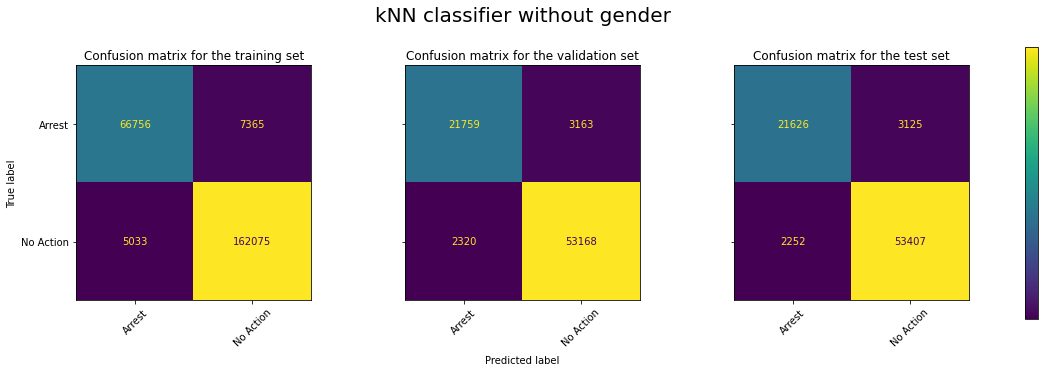

In [73]:
cm_train_knn_gender = confusion_matrix(y_train, y_pred_train_nogender)
cm_val_knn_gender = confusion_matrix(y_val, y_pred_val_nogender)
cm_test_knn_gender = confusion_matrix(y_test, y_pred_test_nogender)

tmp_dict = {'training': cm_train_knn_gender, 'validation': cm_val_knn_gender, 'test': cm_test_knn_gender}
plot_cm_subplots(tmp_dict, 'kNN classifier without gender')

### Without age

In [ ]:
# Create an instance of KNN with n_neighbors=5 
knn_noage = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
print("Created an instance of KNN")

# Train the model on the training set with the encoded labels
knn_noage.fit(X_train_noage, y_train)
print("Fitting complete")

#predictions for training, validation and test set:
y_pred_train_noage = knn_noage.predict(X_train_noage)
print("Training prediction complete")
y_pred_val_noage = knn_noage.predict(X_val_noage)
print("Validation prediction complete")
y_pred_test_noage = knn_noage.predict(X_test_noage)
print("Test prediction complete")

pred_score_knn_noage = accuracy_score(y_test, y_pred_test_noage)
print("Accuracy score calculated")

In [ ]:
print(pred_score_knn_noage)

In [ ]:
# Save the classifier and the variables to disk
# pickle.dump(knn_noage, open('pickles/knn_noage.sav', 'wb'))
# pickle.dump(y_pred_train_noage, open('pickles/y_pred_train_noage.sav', 'wb'))
# pickle.dump(y_pred_val_noage, open('pickles/y_pred_val_noage.sav', 'wb'))
# pickle.dump(y_pred_test_noage, open('pickles/y_pred_test_noage.sav', 'wb'))

#### Confusion matrices

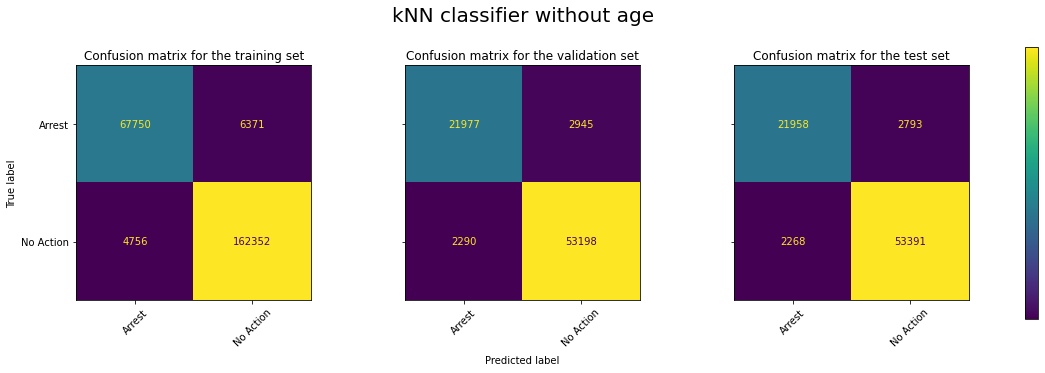

In [74]:
cm_train_knn_age = confusion_matrix(y_train, y_pred_train_noage)
cm_val_knn_age = confusion_matrix(y_val, y_pred_val_noage)
cm_test_knn_age = confusion_matrix(y_test, y_pred_test_noage)

tmp_dict = {'training': cm_train_knn_age, 'validation': cm_val_knn_age, 'test': cm_test_knn_age}
plot_cm_subplots(tmp_dict, 'kNN classifier without age')

### Without any sensitive features

In [ ]:
# Create an instance of KNN with n_neighbors=5 
knn_unaw = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
print("Created an instance of KNN")

# Train the model on the training set with the encoded labels
knn_unaw.fit(X_train_unaw, y_train)
print("Fitting complete")

#predictions for training, validation and test set:
y_pred_train_unaw = knn_unaw.predict(X_train_unaw)
print("Training prediction complete")
y_pred_val_unaw = knn_unaw.predict(X_val_unaw)
print("Validation prediction complete")
y_pred_test_unaw = knn_unaw.predict(X_test_unaw)
print("Test prediction complete")

pred_score_knn_unaw = accuracy_score(y_test, y_pred_test_unaw)
print("Accuracy score calculated")

In [ ]:
print(pred_score_knn_unaw) # the accuracy score improved

In [ ]:
# Save the classifier and the variables to disk
# pickle.dump(knn_unaw, open('pickles/knn_unaw.sav', 'wb'))
# pickle.dump(y_pred_train_unaw, open('pickles/y_pred_train_unaw.sav', 'wb'))
# pickle.dump(y_pred_val_unaw, open('pickles/y_pred_val_unaw.sav', 'wb'))
# pickle.dump(y_pred_test_unaw, open('pickles/y_pred_test_unaw.sav', 'wb'))

#### Confusion matrices

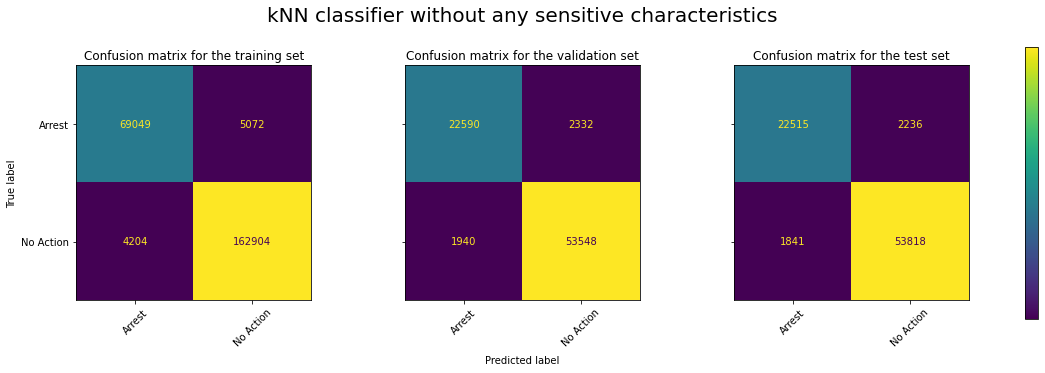

In [76]:
cm_train_knn_unaw = confusion_matrix(y_train, y_pred_train_unaw)
cm_val_knn_unaw = confusion_matrix(y_val, y_pred_val_unaw)
cm_test_knn_unaw = confusion_matrix(y_test, y_pred_test_unaw)

tmp_dict = {'training': cm_train_knn_unaw, 'validation': cm_val_knn_unaw, 'test': cm_test_knn_unaw}
plot_cm_subplots(tmp_dict, 'kNN classifier without any sensitive characteristics')

## Fairness criteria for the new matrices

### Race groups

In [77]:
#split into races
group_asian = X_test['driver_race_Asian'] == 1
group_black = X_test['driver_race_Black'] == 1
group_white = X_test['driver_race_White'] == 1
group_hispanic = X_test['driver_race_Hispanic'] == 1
group_other = X_test['driver_race_Other'] == 1 

#define variable for each race
y_pred_asian_norace = y_pred_test_norace[group_asian]
y_test_asian = y_test[group_asian]
X_test_asian_norace = X_test_norace[group_asian]

y_pred_black_norace = y_pred_test_norace[group_black]
y_test_black = y_test[group_black]
X_test_black_norace = X_test_norace[group_black]

y_pred_white_norace = y_pred_test_norace[group_white]
y_test_white = y_test[group_white]
X_test_white_norace = X_test_norace[group_white]

y_pred_hispanic_norace = y_pred_test_norace[group_hispanic]
y_test_hispanic = y_test[group_hispanic]
X_test_hispanic_norace = X_test_norace[group_hispanic]

y_pred_other_norace = y_pred_test_norace[group_other]
y_test_other = y_test[group_other]
X_test_other_norace = X_test_norace[group_other]

#### Confusion matrices

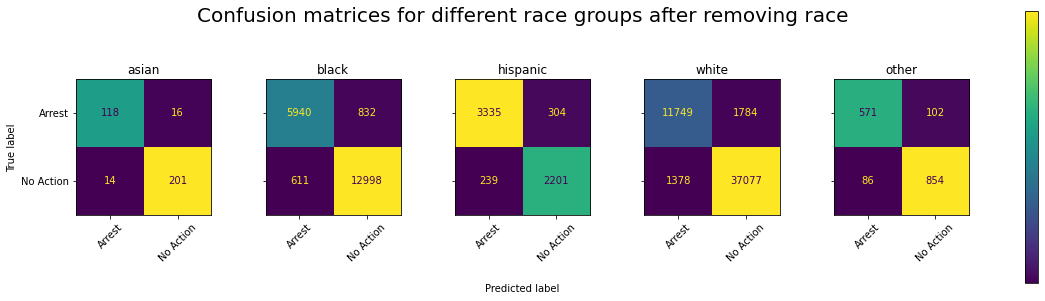

In [78]:
#calculate confusion matrix values
cm_asian_norace = confusion_matrix(y_test_asian, y_pred_asian_norace)
cm_black_norace = confusion_matrix(y_test_black, y_pred_black_norace)
cm_white_norace = confusion_matrix(y_test_white, y_pred_white_norace)
cm_hispanic_norace = confusion_matrix(y_test_hispanic, y_pred_hispanic_norace)
cm_other_norace = confusion_matrix(y_test_other, y_pred_other_norace)

tmp_dict = {'asian': cm_asian_norace, 'black': cm_black_norace, 'hispanic': cm_hispanic_norace, 'white': cm_white_norace, 'other': cm_other_norace}
plot_cm_subplots(tmp_dict, 'Confusion matrices for different race groups after removing race', 0.1, 0.85, '')

In [79]:
#calculate true negative, false positive, false negative and true positive
tn_asian_norace, fp_asian_norace, fn_asian_norace, tp_asian_norace = confusion_matrix(y_test_asian, y_pred_asian_norace).ravel()
tn_black_norace, fp_black_norace, fn_black_norace, tp_black_norace = confusion_matrix(y_test_black, y_pred_black_norace).ravel()
tn_white_norace, fp_white_norace, fn_white_norace, tp_white_norace = confusion_matrix(y_test_white, y_pred_white_norace).ravel()
tn_hispanic_norace, fp_hispanic_norace, fn_hispanic_norace, tp_hispanic_norace = confusion_matrix(y_test_hispanic, y_pred_hispanic_norace).ravel()
tn_other_norace, fp_other_norace, fn_other_norace, tp_other_norace = confusion_matrix(y_test_other, y_pred_other_norace).ravel()

#### Fairness Metrics for race groups (with race dropped)

- the fairness metrics for the current model where race is dropped
- the current fairness metrics are compared with the ones from previous task (where race is included)

In [80]:
#independence:
ind_asian_norace = independence(tn_asian_norace, fp_asian_norace, fn_asian_norace, tp_asian_norace)
ind_black_norace = independence(tn_black_norace, fp_black_norace, fn_black_norace, tp_black_norace)
ind_white_norace = independence(tn_white_norace, fp_white_norace, fn_white_norace, tp_white_norace)
ind_hispanic_norace = independence(tn_hispanic_norace, fp_hispanic_norace, fn_hispanic_norace, tp_hispanic_norace)
ind_other_norace = independence(tn_other_norace, fp_other_norace, fn_other_norace, tp_other_norace)

In [81]:
print(ind_asian_norace, ind_black_norace, ind_white_norace, ind_hispanic_norace, ind_other_norace)
print(ind_asian, ind_black, ind_white, ind_hispanic, ind_other)

0.6217765042979942 0.6785731809037829 0.7474994229437563 0.4120743543345945 0.592684438933664
0.667621776504298 0.6752367401010745 0.7523274601831191 0.4050008225037013 0.597024178549287


In [82]:
#separation:
sep_asian_norace = separation(tn_asian_norace, fp_asian_norace, fn_asian_norace, tp_asian_norace)
sep_black_norace = separation(tn_black_norace, fp_black_norace, fn_black_norace, tp_black_norace)
sep_white_norace = separation(tn_white_norace, fp_white_norace, fn_white_norace, tp_white_norace)
sep_hispanic_norace = separation(tn_hispanic_norace, fp_hispanic_norace, fn_hispanic_norace, tp_hispanic_norace)
sep_other_norace = separation(tn_other_norace, fp_other_norace, fn_other_norace, tp_other_norace)

In [83]:
#comparing separation scores (previous and current with features dropped)
print(sep_asian_norace, sep_black_norace, sep_white_norace, sep_hispanic_norace, sep_other_norace)
print(sep_asian, sep_black, sep_white, sep_hispanic, sep_other)

(0.9262672811059908, 0.8939393939393939) (0.9398409255242227, 0.9067317966722638) (0.9540927922595919, 0.895025519920774) (0.8786427145708583, 0.9331281477336317) (0.893305439330544, 0.8691019786910198)
(0.8755364806866953, 0.9051724137931034) (0.9407789565470135, 0.8999848919776401) (0.9510124769891594, 0.9022211867039454) (0.8805848903330625, 0.9247995576444568) (0.8847352024922118, 0.8646153846153846)


In [84]:
#sufficiency
suf_asian_norace = sufficiency(tn_asian_norace, fp_asian_norace, fn_asian_norace, tp_asian_norace)
suf_black_norace = sufficiency(tn_black_norace, fp_black_norace, fn_black_norace, tp_black_norace)
suf_white_norace = sufficiency(tn_white_norace, fp_white_norace, fn_white_norace, tp_white_norace)
suf_hispanic_norace = sufficiency(tn_hispanic_norace, fp_hispanic_norace, fn_hispanic_norace, tp_hispanic_norace)
suf_other_norace = sufficiency(tn_other_norace, fp_other_norace, fn_other_norace, tp_other_norace)

In [85]:
#comparing sufficiency scores (previous and current with features dropped)
print(suf_asian_norace, suf_black_norace, suf_white_norace, suf_hispanic_norace, suf_other_norace)
print(suf_asian, suf_black, suf_white, suf_hispanic, suf_other)

(0.9348837209302325, 0.11940298507462686) (0.9551032405026085, 0.12285883047844064) (0.9641659082043947, 0.13182590704204536) (0.9020491803278688, 0.08353943391041495) (0.9085106382978724, 0.1515601783060921)
(0.9488372093023256, 0.21641791044776118) (0.9513557204790947, 0.12034849379799173) (0.9672604342738266, 0.1415798418680263) (0.8885245901639345, 0.0807914262159934) (0.9063829787234042, 0.1649331352154532)


### Age groups

In [86]:
#split into age groups (see above)
group_young = X_test['driver_age'] < 30
group_middle = (X_test['driver_age'] >= 30) & (X_test['driver_age'] < 65)
group_elderly = X_test['driver_age'] >= 65

In [87]:
y_pred_young_noage = y_pred_test_noage[group_young]
y_test_young = y_test[group_young]
X_test_young_noage = X_test_noage[group_young]

y_pred_middle_noage = y_pred_test_noage[group_middle]
y_test_middle = y_test[group_middle]
X_test_middle_noage = X_test_noage[group_middle]

y_pred_elderly_noage = y_pred_test_noage[group_elderly]
y_test_elderly = y_test[group_elderly]
X_test_elderly_noage = X_test_noage[group_elderly]

#### Confusion matrices

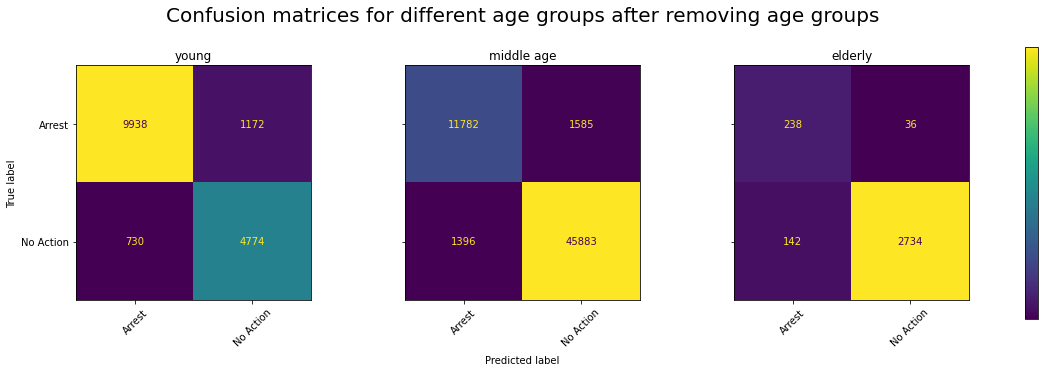

In [88]:
#confusion matrix
cm_young_noage = confusion_matrix(y_test_young, y_pred_young_noage)
cm_middle_noage = confusion_matrix(y_test_middle, y_pred_middle_noage)
cm_elderly_noage = confusion_matrix(y_test_elderly, y_pred_elderly_noage)

tmp_dict = {'young': cm_young_noage, 'middle age': cm_middle_noage, 'elderly': cm_elderly_noage}
plot_cm_subplots(tmp_dict, 'Confusion matrices for different age groups after removing age groups', 0, 0.95, '')

In [89]:
#calculate true negative, false positive, false negative and true positive
tn_young_noage, fp_young_noage, fn_young_noage, tp_young_noage = confusion_matrix(y_test_young, y_pred_young_noage).ravel()
tn_middle_noage, fp_middle_noage, fn_middle_noage, tp_middle_noage = confusion_matrix(y_test_middle, y_pred_middle_noage).ravel()
tn_elderly_noage, fp_elderly_noage, fn_elderly_noage, tp_elderly_noage = confusion_matrix(y_test_elderly, y_pred_elderly_noage).ravel()

#### Fairness metrics for age groups (with age dropped)

- the fairness metrics for the current model where age is dropped
- the current fairness metrics are compared with the ones from previous task (where age is included)

In [90]:
#independence
ind_young_noage = independence(tn_young_noage, fp_young_noage, fn_young_noage, tp_young_noage)
ind_middle_noage = independence(tn_middle_noage, fp_middle_noage, fn_middle_noage, tp_middle_noage)
ind_elderly_noage = independence(tn_elderly_noage, fp_elderly_noage, fn_elderly_noage, tp_elderly_noage)

In [91]:
print(ind_young_noage, ind_middle_noage, ind_elderly_noage)
print(ind_young, ind_middle, ind_elderly)

0.3578909353557241 0.7827061966164298 0.8793650793650793
0.3293607800650054 0.793638492233618 0.9298412698412698


In [92]:
#separation
sep_young_noage = separation(tn_young_noage, fp_young_noage, fn_young_noage, tp_young_noage)
sep_middle_noage = separation(tn_middle_noage, fp_middle_noage, fn_middle_noage, tp_middle_noage)
sep_elderly_noage = separation(tn_elderly_noage, fp_elderly_noage, fn_elderly_noage, tp_elderly_noage)

In [93]:
print(sep_young_noage, sep_middle_noage, sep_elderly_noage)
print(sep_young, sep_middle, sep_elderly)

(0.8028927009754456, 0.9315710536182977) (0.966609084014494, 0.8940658673546821) (0.9870036101083033, 0.6263157894736842)
(0.8154239766081871, 0.906479985639921) (0.9570339282375184, 0.9028365960846984) (0.9702970297029703, 0.8461538461538461)


In [94]:
#sufficiency
suf_young_noage = sufficiency(tn_young_noage, fp_young_noage, fn_young_noage, tp_young_noage)
suf_middle_noage = sufficiency(tn_middle_noage, fp_middle_noage, fn_middle_noage, tp_middle_noage)
suf_elderly_noage = sufficiency(tn_elderly_noage, fp_elderly_noage, fn_elderly_noage, tp_elderly_noage)

In [95]:
print(suf_young_noage, suf_middle_noage, suf_elderly_noage)
print(suf_young, suf_middle, suf_elderly)

(0.8673691860465116, 0.10549054905490549) (0.9704731487552614, 0.11857559661853818) (0.9506258692628651, 0.13138686131386862)
(0.8106831395348837, 0.09090909090909091) (0.9742803358785084, 0.15470935886885614) (0.9881780250347705, 0.3175182481751825)


### Gender groups

In [96]:
#gender groups:
group_female = X_test['driver_gender'] == 0
group_male = X_test['driver_gender'] == 1

In [97]:
y_pred_female_nogender = y_pred_test_nogender[group_female]
y_test_female = y_test[group_female]
X_test_female_nogender = X_test_nogender[group_female]

y_pred_male_nogender = y_pred_test_nogender[group_male]
y_test_male = y_test[group_male]
X_test_male_nogender = X_test_nogender[group_male]

#### Confusion matrices

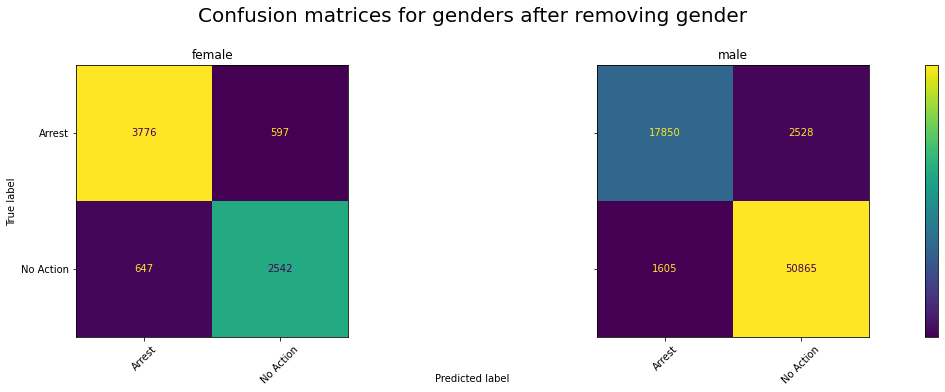

In [98]:
#confusion matrix
cm_female_nogender = confusion_matrix(y_test_female, y_pred_female_nogender)
cm_male_nogender = confusion_matrix(y_test_male, y_pred_male_nogender)

tmp_dict = {'female': cm_female_nogender, 'male': cm_male_nogender}
plot_cm_subplots(tmp_dict, 'Confusion matrices for genders after removing gender', 0, 1, '')

In [99]:
#calculate true negative, false positive, false negative and true positive
tn_female_nogender, fp_female_nogender, fn_female_nogender, tp_female_nogender = confusion_matrix(y_test_female, y_pred_female_nogender).ravel()
tn_male_nogender, fp_male_nogender, fn_male_nogender, tp_male_nogender = confusion_matrix(y_test_male, y_pred_male_nogender).ravel()

#### Fairness Metrics for gender groups (gender is dropped)

- the fairness metrics for the current model where gender is dropped
- the current fairness metrics are compared with the ones from previous task (where gender is included)

In [100]:
#independence
ind_female_nogender = independence(tn_female_nogender, fp_female_nogender, fn_female_nogender, tp_female_nogender)
ind_male_nogender = independence(tn_male_nogender, fp_male_nogender, fn_male_nogender, tp_male_nogender)

In [101]:
print(ind_female_nogender, ind_male_nogender)
print(ind_female, ind_male)

0.4151018249140439 0.7329370744564023
0.43321872520497223 0.7310564462991435


In [102]:
#separation
sep_female_nogender = separation(tn_female_nogender, fp_female_nogender, fn_female_nogender, tp_female_nogender)
sep_male_nogender = separation(tn_male_nogender, fp_male_nogender, fn_male_nogender, tp_male_nogender)

In [103]:
print(sep_female_nogender, sep_male_nogender)
print(sep_female, sep_male)

(0.8098120420516088, 0.8537191951164368) (0.9526529694903826, 0.9175019275250579)
(0.778998778998779, 0.851376574895007) (0.9541647889439687, 0.9155267456104532)


In [104]:
#sufficiency
suf_female_nogender = sufficiency(tn_female_nogender, fp_female_nogender, fn_female_nogender, tp_female_nogender)
suf_male_nogender = sufficiency(tn_male_nogender, fp_male_nogender, fn_male_nogender, tp_male_nogender)

In [105]:
print(suf_female_nogender, suf_male_nogender)
print(suf_female, suf_male)

(0.7971150830981499, 0.13651955179510633) (0.9694110920526015, 0.12405535381293552)
(0.8002508623392913, 0.16556139949691287) (0.9684581665713741, 0.11978604377269604)


### Without any sensitive features (where race, gender, and age are dropped)

#### Fairness metrics for race groups

In [106]:
#split into races
group_asian = X_test['driver_race_Asian'] == 1
group_black = X_test['driver_race_Black'] == 1
group_white = X_test['driver_race_White'] == 1
group_hispanic = X_test['driver_race_Hispanic'] == 1
group_other = X_test['driver_race_Other'] == 1 

#define variable for each race
y_pred_asian_unaw = y_pred_test_unaw[group_asian]
y_test_asian = y_test[group_asian]
X_test_asian_unaw = X_test_unaw[group_asian]

y_pred_black_unaw = y_pred_test_unaw[group_black]
y_test_black = y_test[group_black]
X_test_black_unaw = X_test_unaw[group_black]

y_pred_white_unaw = y_pred_test_unaw[group_white]
y_test_white = y_test[group_white]
X_test_white_unaw = X_test_unaw[group_white]

y_pred_hispanic_unaw = y_pred_test_unaw[group_hispanic]
y_test_hispanic = y_test[group_hispanic]
X_test_hispanic_unaw = X_test_unaw[group_hispanic]

y_pred_other_unaw = y_pred_test_unaw[group_other]
y_test_other = y_test[group_other]
X_test_other_unaw = X_test_unaw[group_other]

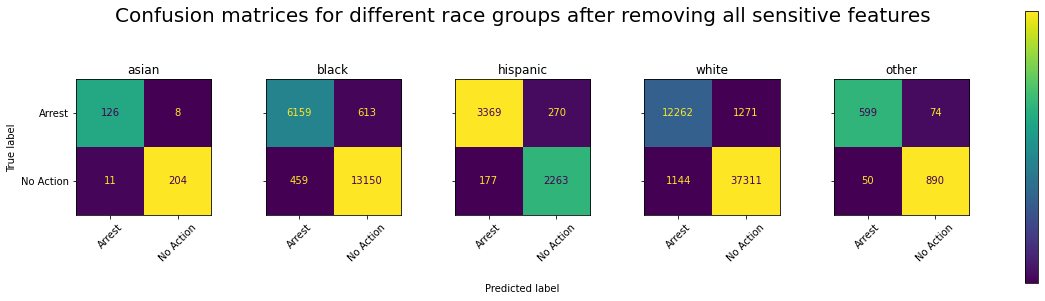

In [107]:
#calculate confusion matrix values
cm_asian_unaw = confusion_matrix(y_test_asian, y_pred_asian_unaw)
cm_black_unaw = confusion_matrix(y_test_black, y_pred_black_unaw)
cm_white_unaw = confusion_matrix(y_test_white, y_pred_white_unaw)
cm_hispanic_unaw = confusion_matrix(y_test_hispanic, y_pred_hispanic_unaw)
cm_other_unaw = confusion_matrix(y_test_other, y_pred_other_unaw)

tmp_dict = {'asian': cm_asian_unaw, 'black': cm_black_unaw, 'hispanic': cm_hispanic_unaw, 'white': cm_white_unaw, 'other': cm_other_unaw}
plot_cm_subplots(tmp_dict, 'Confusion matrices for different race groups after removing all sensitive features', 0.1, 0.85, '')

In [108]:
#calculate true negative, false positive, false negative and true positive
tn_asian_unaw, fp_asian_unaw, fn_asian_unaw, tp_asian_unaw = confusion_matrix(y_test_asian, y_pred_asian_unaw).ravel()
tn_black_unaw, fp_black_unaw, fn_black_unaw, tp_black_unaw = confusion_matrix(y_test_black, y_pred_black_unaw).ravel()
tn_white_unaw, fp_white_unaw, fn_white_unaw, tp_white_unaw = confusion_matrix(y_test_white, y_pred_white_unaw).ravel()
tn_hispanic_unaw, fp_hispanic_unaw, fn_hispanic_unaw, tp_hispanic_unaw = confusion_matrix(y_test_hispanic, y_pred_hispanic_unaw).ravel()
tn_other_unaw, fp_other_unaw, fn_other_unaw, tp_other_unaw = confusion_matrix(y_test_other, y_pred_other_unaw).ravel()

#independence:
ind_asian_unaw = independence(tn_asian_unaw, fp_asian_unaw, fn_asian_unaw, tp_asian_unaw)
ind_black_unaw = independence(tn_black_unaw, fp_black_unaw, fn_black_unaw, tp_black_unaw)
ind_white_unaw = independence(tn_white_unaw, fp_white_unaw, fn_white_unaw, tp_white_unaw)
ind_hispanic_unaw = independence(tn_hispanic_unaw, fp_hispanic_unaw, fn_hispanic_unaw, tp_hispanic_unaw)
ind_other_unaw = independence(tn_other_unaw, fp_other_unaw, fn_other_unaw, tp_other_unaw)

print("Order: Asian, Black, White, Hispanic, other")
print("Independence:", ind_asian_unaw, ind_black_unaw, ind_white_unaw, ind_hispanic_unaw, ind_other_unaw)


#separation:
sep_asian_unaw = separation(tn_asian_unaw, fp_asian_unaw, fn_asian_unaw, tp_asian_unaw)
sep_black_unaw = separation(tn_black_unaw, fp_black_unaw, fn_black_unaw, tp_black_unaw)
sep_white_unaw = separation(tn_white_unaw, fp_white_unaw, fn_white_unaw, tp_white_unaw)
sep_hispanic_unaw = separation(tn_hispanic_unaw, fp_hispanic_unaw, fn_hispanic_unaw, tp_hispanic_unaw)
sep_other_unaw = separation(tn_other_unaw, fp_other_unaw, fn_other_unaw, tp_other_unaw)

print("Separation:", sep_asian_unaw, sep_black_unaw, sep_white_unaw, sep_hispanic_unaw, sep_other_unaw)

#sufficiency
suf_asian_unaw = sufficiency(tn_asian_unaw, fp_asian_unaw, fn_asian_unaw, tp_asian_unaw)
suf_black_unaw = sufficiency(tn_black_unaw, fp_black_unaw, fn_black_unaw, tp_black_unaw)
suf_white_unaw = sufficiency(tn_white_unaw, fp_white_unaw, fn_white_unaw, tp_white_unaw)
suf_hispanic_unaw = sufficiency(tn_hispanic_unaw, fp_hispanic_unaw, fn_hispanic_unaw, tp_hispanic_unaw)
suf_other_unaw = sufficiency(tn_other_unaw, fp_other_unaw, fn_other_unaw, tp_other_unaw)

print("Sufficiency:", suf_asian_unaw, suf_black_unaw, suf_white_unaw, suf_hispanic_unaw, suf_other_unaw)

Order: Asian, Black, White, Hispanic, other
Independence: 0.6074498567335244 0.6752858054069967 0.7421327998768946 0.41668037506168776 0.5976441413515189
Separation: (0.9622641509433962, 0.9197080291970803) (0.955460292087481, 0.9306436990027198) (0.9670571769218806, 0.9146650753394002) (0.8934070272404264, 0.9500846023688664) (0.9232365145228216, 0.9229583975346687)
Sufficiency: (0.9488372093023256, 0.05970149253731343) (0.9662723197883754, 0.09051978735971648) (0.9702509426602522, 0.09391856942289219) (0.9274590163934426, 0.0741962077493817) (0.9468085106382979, 0.1099554234769688)


#### Fairness metrics for age groups

In [109]:
#split into age groups (see above)
group_young = X_test['driver_age'] < 30
group_middle = (X_test['driver_age'] >= 30) & (X_test['driver_age'] < 65)
group_elderly = X_test['driver_age'] >= 65

y_pred_young_unaw = y_pred_test_unaw[group_young]
y_test_young = y_test[group_young]
X_test_young_unaw = X_test_unaw[group_young]

y_pred_middle_unaw = y_pred_test_unaw[group_middle]
y_test_middle = y_test[group_middle]
X_test_middle_unaw = X_test_unaw[group_middle]

y_pred_elderly_unaw = y_pred_test_unaw[group_elderly]
y_test_elderly = y_test[group_elderly]
X_test_elderly_unaw = X_test_unaw[group_elderly]

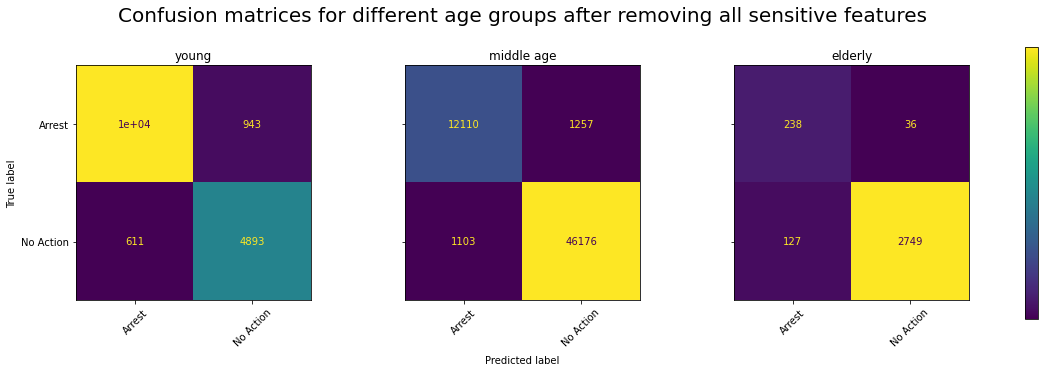

In [110]:
#confusion matrix
cm_young_unaw = confusion_matrix(y_test_young, y_pred_young_unaw)
cm_middle_unaw = confusion_matrix(y_test_middle, y_pred_middle_unaw)
cm_elderly_unaw = confusion_matrix(y_test_elderly, y_pred_elderly_unaw)

#plot confusion matrix
tmp_dict = {'young': cm_young_unaw, 'middle age': cm_middle_unaw, 'elderly': cm_elderly_unaw}
plot_cm_subplots(tmp_dict, 'Confusion matrices for different age groups after removing all sensitive features', 0, 0.95, '')

In [111]:
#calculate true negative, false positive, false negative and true positive
tn_young_unaw, fp_young_unaw, fn_young_unaw, tp_young_unaw = confusion_matrix(y_test_young, y_pred_young_unaw).ravel()
tn_middle_unaw, fp_middle_unaw, fn_middle_unaw, tp_middle_unaw = confusion_matrix(y_test_middle, y_pred_middle_unaw).ravel()
tn_elderly_unaw, fp_elderly_unaw, fn_elderly_unaw, tp_elderly_unaw = confusion_matrix(y_test_elderly, y_pred_elderly_unaw).ravel()

#independence
ind_young_unaw = independence(tn_young_unaw, fp_young_unaw, fn_young_unaw, tp_young_unaw)
ind_middle_unaw = independence(tn_middle_unaw, fp_middle_unaw, fn_middle_unaw, tp_middle_unaw)
ind_elderly_unaw = independence(tn_elderly_unaw, fp_elderly_unaw, fn_elderly_unaw, tp_elderly_unaw)

print("Order: Young, Middle aged, elderly")
print("Independence:", ind_young_unaw, ind_middle_unaw, ind_elderly_unaw)

#separation
sep_young_unaw = separation(tn_young_unaw, fp_young_unaw, fn_young_unaw, tp_young_unaw)
sep_middle_unaw = separation(tn_middle_unaw, fp_middle_unaw, fn_middle_unaw, tp_middle_unaw)
sep_elderly_unaw = separation(tn_elderly_unaw, fp_elderly_unaw, fn_elderly_unaw, tp_elderly_unaw)

print("Separation:", sep_young_unaw, sep_middle_unaw, sep_elderly_unaw)

#sufficiency
suf_young_unaw = sufficiency(tn_young_unaw, fp_young_unaw, fn_young_unaw, tp_young_unaw)
suf_middle_unaw = sufficiency(tn_middle_unaw, fp_middle_unaw, fn_middle_unaw, tp_middle_unaw)
suf_elderly_unaw = sufficiency(tn_elderly_unaw, fp_elderly_unaw, fn_elderly_unaw, tp_elderly_unaw)

print("Sufficiency:", suf_young_unaw, suf_middle_unaw, suf_elderly_unaw)

Order: Young, Middle aged, elderly
Independence: 0.3512700132418442 0.7821290769382977 0.8841269841269841
Separation: (0.8384167237834133, 0.9433104472072741) (0.9734994623995952, 0.9165216075077575) (0.9870736086175943, 0.6520547945205479)
Sufficiency: (0.8889898255813954, 0.08487848784878488) (0.9766704033503246, 0.0940375551731877) (0.9558414464534075, 0.13138686131386862)


#### Fairness metrics for gender groups

In [112]:
#gender groups:
group_female = X_test['driver_gender'] == 0
group_male = X_test['driver_gender'] == 1

y_pred_female_unaw = y_pred_test_unaw[group_female]
y_test_female = y_test[group_female]
X_test_female_unaw = X_test_unaw[group_female]

y_pred_male_unaw = y_pred_test_unaw[group_male]
y_test_male = y_test[group_male]
X_test_male_unaw = X_test_unaw[group_male]

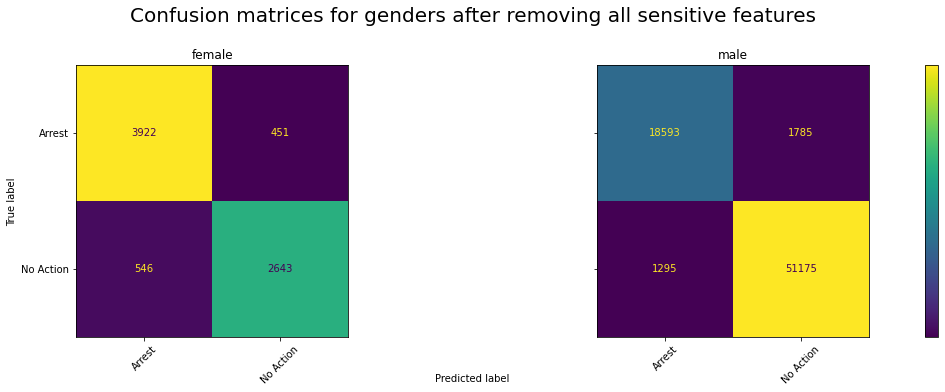

In [113]:
#confusion matrix
cm_female_unaw = confusion_matrix(y_test_female, y_pred_female_unaw)
cm_male_unaw = confusion_matrix(y_test_male, y_pred_male_unaw)

#plot the confusion matrix
tmp_dict = {'female': cm_female_unaw, 'male': cm_male_unaw}
plot_cm_subplots(tmp_dict, 'Confusion matrices for genders after removing all sensitive features', 0, 1, '')

In [114]:
#calculate true negative, false positive, false negative and true positive
tn_female_unaw, fp_female_unaw, fn_female_unaw, tp_female_unaw = confusion_matrix(y_test_female, y_pred_female_unaw).ravel()
tn_male_unaw, fp_male_unaw, fn_male_unaw, tp_male_unaw = confusion_matrix(y_test_male, y_pred_male_unaw).ravel()

#independence
ind_female_unaw = independence(tn_female_unaw, fp_female_unaw, fn_female_unaw, tp_female_unaw)
ind_male_unaw = independence(tn_male_unaw, fp_male_unaw, fn_male_unaw, tp_male_unaw)

print("Order: Female, Male")
print("Independence:", ind_female_unaw, ind_male_unaw)

#separation
sep_female_unaw = separation(tn_female_unaw, fp_female_unaw, fn_female_unaw, tp_female_unaw)
sep_male_unaw = separation(tn_male_unaw, fp_male_unaw, fn_male_unaw, tp_male_unaw)

print("Separation:", sep_female_unaw, sep_male_unaw)

#sufficiency
suf_female_unaw = sufficiency(tn_female_unaw, fp_female_unaw, fn_female_unaw, tp_female_unaw)
suf_male_unaw = sufficiency(tn_male_unaw, fp_male_unaw, fn_male_unaw, tp_male_unaw)

print("Sufficiency:", suf_female_unaw, suf_male_unaw)

Order: Female, Male
Independence: 0.40915101824914046 0.726993191302438
Separation: (0.8542340012928248, 0.877797672336616) (0.9662953172205438, 0.9348853580048271)
Sufficiency: (0.8287864534336783, 0.10313286073633661) (0.9753192300362111, 0.08759446461870644)


## Display the fairness metrics in dataframes for better visualization

- Fairness metrics for race groups when all sensitive features are included
- Fairness metrics for race groups when race is dropped


- Fairness metrics for age groups when all sensitive features are included
- Fairness metrics for age groups when age is dropped


- Fairness metrics for gender groups when all sensitive features are included
- Fairness metrics for gender groups when gender is dropped


- Fairness metrics for race groups when race, age, gender are dropped
- Fairness metrics for age groups when race, age, gender are dropped
- Fairness metrics for gender groups when race, age, gender are dropped

In [115]:
#race lists
independence_list_race = np.around(np.array([ind_white, ind_black, ind_hispanic, ind_asian, ind_other]), 4)
separation_list_race = np.around(np.array([sep_white, sep_black, sep_hispanic, sep_asian, sep_other]), 4).tolist()
sufficiency_list_race = np.around(np.array([suf_white, suf_black, suf_hispanic, suf_asian, suf_other]), 4).tolist()
#age lists
independence_list_age = np.around(np.array([ind_young, ind_middle, ind_elderly]), 4)
separation_list_age = np.around(np.array([sep_young, sep_middle, sep_elderly]), 4).tolist()
sufficiency_list_age = np.around(np.array([suf_young, suf_middle, suf_elderly]), 4).tolist()
#gender lists
independence_list_gender = np.around(np.array([ind_male, ind_female]), 4)
separation_list_gender = np.around(np.array([sep_male, sep_female]), 4).tolist()
sufficiency_list_gender = np.around(np.array([suf_male, suf_female]), 4).tolist()
#no race lists
independence_list_norace = np.around(np.array([ind_white_norace, ind_black_norace, ind_hispanic_norace, ind_asian_norace, ind_other_norace]), 4)
separation_list_norace = np.around(np.array([sep_white_norace, sep_black_norace, sep_hispanic_norace, sep_asian_norace, sep_other_norace]), 4).tolist()
sufficiency_list_norace = np.around(np.array([suf_white_norace, suf_black_norace, suf_hispanic_norace, suf_asian_norace, suf_other_norace]), 4).tolist()
#no age lists
independence_list_noage = np.around(np.array([ind_young_noage, ind_middle_noage, ind_elderly_noage]), 4)
separation_list_noage = np.around(np.array([sep_young_noage, sep_middle_noage, sep_elderly_noage]), 4).tolist()
sufficiency_list_noage = np.around(np.array([suf_young_noage, suf_middle_noage, suf_elderly_noage]), 4).tolist()
#no gender lists
independence_list_nogender = np.around(np.array([ind_male_nogender, ind_female_nogender]), 4)
separation_list_nogender = np.around(np.array([sep_male_nogender, sep_female_nogender]), 4).tolist()
sufficiency_list_nogender = np.around(np.array([suf_male_nogender, suf_female_nogender]), 4).tolist()

#no race, age, gender lists
independence_list_race_unaw = np.around(np.array([ind_asian_unaw, ind_black_unaw, ind_white_unaw, ind_hispanic_unaw, ind_other_unaw]), 4)
separation_list_race_unaw = np.around(np.array([sep_asian_unaw, sep_black_unaw, sep_white_unaw, sep_hispanic_unaw, sep_other_unaw]), 4).tolist()
sufficiency_list_race_unaw = np.around(np.array([suf_asian_unaw, suf_black_unaw, suf_white_unaw, suf_hispanic_unaw, suf_other_unaw]), 4).tolist()

independence_list_age_unaw = np.around(np.array([ind_young_unaw, ind_middle_unaw, ind_elderly_unaw]), 4)
separation_list_age_unaw = np.around(np.array([sep_young_unaw, sep_middle_unaw, sep_elderly_unaw]), 4).tolist()
sufficiency_list_age_unaw = np.around(np.array([suf_young_unaw, suf_middle_unaw, suf_elderly_unaw]), 4).tolist()

independence_list_gender_unaw = np.around(np.array([ind_male_unaw, ind_female_unaw]), 4)
separation_list_gender_unaw = np.around(np.array([sep_male_unaw, sep_female_unaw]), 4).tolist()
sufficiency_list_gender_unaw = np.around(np.array([suf_male_unaw, suf_female_unaw]), 4).tolist()

In [116]:
#create table to store fairness value for race
race_columns = ['White','Black','Hispanic','Asian','Other']
fairness_index = ['Independency','Separation','Sufficiency']
fairness_table_race = pd.DataFrame(columns = race_columns, index = fairness_index)
fairness_table_race_drop = fairness_table_race

#create table to store fairness value for gender
gender_columns = ['Male','Female']
fairness_table_gender = pd.DataFrame(columns = gender_columns, index = fairness_index)
fairness_table_gender_drop = fairness_table_gender

#create table to store fairness value for age
age_columns = ['Young','Middle age','Elderly']
fairness_table_age = pd.DataFrame(columns = age_columns, index = fairness_index)
fairness_table_age_drop = fairness_table_age

#### Dataframe for fairness metrics (with and without dropping race from data set)

In [117]:
#adding values for fairness table with and without dropping race
#fairness_table_race
#fairness_table_race_drop

print("Fairness metrics for model in which race is included")    
fairness_table_race.loc['Independency'] = independence_list_race
fairness_table_race.loc['Separation'] = separation_list_race
fairness_table_race.loc['Sufficiency'] = sufficiency_list_race
fairness_table_race = fairness_table_race.round(4)
fairness_table_race

Fairness metrics for model in which race is included


,White,Black,Hispanic,Asian,Other
Independency,0.7523,0.6752,0.405,0.6676,0.597
Separation,"[0.951, 0.9022]","[0.9408, 0.9]","[0.8806, 0.9248]","[0.8755, 0.9052]","[0.8847, 0.8646]"
Sufficiency,"[0.9673, 0.1416]","[0.9514, 0.1203]","[0.8885, 0.0808]","[0.9488, 0.2164]","[0.9064, 0.1649]"


In [118]:
print("Fairness metrics for model in which race is dropped")
fairness_table_race_drop.loc['Independency'] = independence_list_norace
fairness_table_race_drop.loc['Separation'] = separation_list_norace
fairness_table_race_drop.loc['Sufficiency'] = sufficiency_list_norace
fairness_table_race_drop

Fairness metrics for model in which race is dropped


,White,Black,Hispanic,Asian,Other
Independency,0.7475,0.6786,0.4121,0.6218,0.5927
Separation,"[0.9541, 0.895]","[0.9398, 0.9067]","[0.8786, 0.9331]","[0.9263, 0.8939]","[0.8933, 0.8691]"
Sufficiency,"[0.9642, 0.1318]","[0.9551, 0.1229]","[0.902, 0.0835]","[0.9349, 0.1194]","[0.9085, 0.1516]"


#### Dataframe for fairness metrics (with and without dropping gender from data set)

In [119]:
#adding values for fairness table with and without dropping gender
#fairness_table_gender
#fairness_table_gender_drop

print("Fairness metrics for model in which gender is included")  
fairness_table_gender.loc['Independency'] = independence_list_gender
fairness_table_gender.loc['Separation'] = separation_list_gender
fairness_table_gender.loc['Sufficiency'] = sufficiency_list_gender
fairness_table_gender

Fairness metrics for model in which gender is included


,Male,Female
Independency,0.7311,0.4332
Separation,"[0.9542, 0.9155]","[0.779, 0.8514]"
Sufficiency,"[0.9685, 0.1198]","[0.8003, 0.1656]"


In [120]:
print("\n Fairness metrics for model in which gender is dropped")
fairness_table_gender_drop.loc['Independency'] = independence_list_nogender
fairness_table_gender_drop.loc['Separation'] = separation_list_nogender
fairness_table_gender_drop.loc['Sufficiency'] = sufficiency_list_nogender
fairness_table_gender_drop


 Fairness metrics for model in which gender is dropped


,Male,Female
Independency,0.7329,0.4151
Separation,"[0.9527, 0.9175]","[0.8098, 0.8537]"
Sufficiency,"[0.9694, 0.1241]","[0.7971, 0.1365]"


#### Dataframe for fairness metrics (with and without dropping age from data set)

In [121]:
#adding values for fairness table with and without dropping age
#fairness_table_age
#fairness_table_age_drop

print("Fairness metrics for model in which age is included")
fairness_table_age.loc['Independency'] = independence_list_age
fairness_table_age.loc['Separation'] = separation_list_age
fairness_table_age.loc['Sufficiency'] = sufficiency_list_age
fairness_table_gender

Fairness metrics for model in which age is included


,Male,Female
Independency,0.7329,0.4151
Separation,"[0.9527, 0.9175]","[0.8098, 0.8537]"
Sufficiency,"[0.9694, 0.1241]","[0.7971, 0.1365]"


In [134]:
print("\n Fairness metrics for model in which age is dropped")
fairness_table_age_drop.loc['Independency'] = independence_list_noage
fairness_table_age_drop.loc['Separation'] = separation_list_noage
fairness_table_age_drop.loc['Sufficiency'] = sufficiency_list_noage
fairness_table_gender_drop


 Fairness metrics for model in which age is dropped


,Male,Female
Independency,0.7329,0.4151
Separation,"[0.9527, 0.9175]","[0.8098, 0.8537]"
Sufficiency,"[0.9694, 0.1241]","[0.7971, 0.1365]"


#### Dataframe for fairness metrics (dropping all sensitive features: race, gender, age)

In [126]:
print("Fairness metrics for race for model in which race, gender, age are dropped")

fairness_table_race_unaw = pd.DataFrame(columns = race_columns, index = fairness_index)

fairness_table_race_unaw.loc['Independency'] = independence_list_race_unaw
fairness_table_race_unaw.loc['Separation'] = separation_list_race_unaw
fairness_table_race_unaw.loc['Sufficiency'] = sufficiency_list_race_unaw
fairness_table_race_unaw = fairness_table_race_unaw.round(4)
fairness_table_race_unaw

Fairness metrics for race for model in which race, gender, age are dropped


,White,Black,Hispanic,Asian,Other
Independency,0.6074,0.6753,0.7421,0.4167,0.5976
Separation,"[0.9623, 0.9197]","[0.9555, 0.9306]","[0.9671, 0.9147]","[0.8934, 0.9501]","[0.9232, 0.923]"
Sufficiency,"[0.9488, 0.0597]","[0.9663, 0.0905]","[0.9703, 0.0939]","[0.9275, 0.0742]","[0.9468, 0.11]"


In [127]:
print("Fairness metrics for age for model in which race, gender, age are dropped")

fairness_table_age_unaw = pd.DataFrame(columns = age_columns, index = fairness_index)

fairness_table_age_unaw.loc['Independency'] = independence_list_age_unaw
fairness_table_age_unaw.loc['Separation'] = separation_list_age_unaw
fairness_table_age_unaw.loc['Sufficiency'] = sufficiency_list_age_unaw
fairness_table_age_unaw = fairness_table_age_unaw.round(4)
fairness_table_age_unaw

Fairness metrics for age for model in which race, gender, age are dropped


,Young,Middle age,Elderly
Independency,0.3513,0.7821,0.8841
Separation,"[0.8384, 0.9433]","[0.9735, 0.9165]","[0.9871, 0.6521]"
Sufficiency,"[0.889, 0.0849]","[0.9767, 0.094]","[0.9558, 0.1314]"


In [128]:
print("Fairness metrics for gender for model in which race, gender, age are dropped")

fairness_table_gender_unaw = pd.DataFrame(columns = gender_columns, index = fairness_index)

fairness_table_gender_unaw.loc['Independency'] = independence_list_gender_unaw
fairness_table_gender_unaw.loc['Separation'] = separation_list_gender_unaw
fairness_table_gender_unaw.loc['Sufficiency'] = sufficiency_list_gender_unaw
fairness_table_gender_unaw = fairness_table_gender_unaw.round(4)
fairness_table_gender_unaw

Fairness metrics for gender for model in which race, gender, age are dropped


,Male,Female
Independency,0.727,0.4092
Separation,"[0.9663, 0.9349]","[0.8542, 0.8778]"
Sufficiency,"[0.9753, 0.0876]","[0.8288, 0.1031]"


# Using different thresholds to predict stop outcome

The 'violation' feature is used to predict whether or not the outcome is arrest. 

From the Original Data, we see the different types of violation and their counts

In [129]:
data['violation'].value_counts()

Other                  280809
DUI                     47071
Speeding                33779
Seat belt               11017
Registration/plates     10753
Equipment                8412
Safe movement            8194
Stop sign/light          2014
Name: violation, dtype: int64

## Determining which violations are more likely to lead to an arrest

To determine the severeness of each violation, the percentage that leads to an arrest is calculated for all violations.

This percentage is obtained by:

(the number of that particular violation where 'stop_outcome' = arrest) * 100 / (total number of that particular violation)

In [130]:
#calculating percentage of arrestments in regard to each violation
data_violation = data[['violation','stop_outcome']]

list_violations = ['Speeding','DUI','Equipment', 'Seat belt', 'Other', 'Registration/plates', 'Safe movement', 'Stop sign/light']

arrestment_statistics = data_violation['stop_outcome'].value_counts()
print('Total number of arrestments in data set: ', arrestment_statistics)


for element in list_violations:
    frames = data_violation[data_violation['violation']==element]
    counts = frames['stop_outcome'].value_counts()
    print("\n")
    print('Count of {}'.format(element))
    print(counts)
    print('Percentage of arrestments in {} is: '.format(element), counts['Arrest']/(counts[0]+counts[1])*100, '%')

Total number of arrestments in data set:  No Action    278255
Arrest       123794
Name: stop_outcome, dtype: int64


Count of Speeding
Arrest       28422
No Action     5357
Name: stop_outcome, dtype: int64
Percentage of arrestments in Speeding is:  84.14103437046685 %


Count of DUI
Arrest       45656
No Action     1415
Name: stop_outcome, dtype: int64
Percentage of arrestments in DUI is:  96.99390282764335 %


Count of Equipment
No Action    4219
Arrest       4193
Name: stop_outcome, dtype: int64
Percentage of arrestments in Equipment is:  49.8454588682834 %


Count of Seat belt
Arrest       5866
No Action    5151
Name: stop_outcome, dtype: int64
Percentage of arrestments in Seat belt is:  53.24498502314605 %


Count of Other
No Action    254041
Arrest        26768
Name: stop_outcome, dtype: int64
Percentage of arrestments in Other is:  9.532458005263363 %


Count of Registration/plates
No Action    6883
Arrest       3870
Name: stop_outcome, dtype: int64
Percentage of arrestments in R

## Ordering violations severeness and determining threshold for which violations lead to an arrest

After measuring the percentage of each violation that leads to an arrest, these values help in ordering the violations.

Ranking from the worst violation to the least serious violation, the orders are:

- DUI
- Stop sign/light
- Safe movement
- Speeding
- Seat belt
- Equipment 
- Registration/plates
- Other

It is then decided that the 4 worst violations (DUI, Stop sign/light, Safe movement, Speeding) would lead to arrest, while the others would lead to no action.

## Creating a new stop outcome variable using violations as threshold

Create a new dataframe, where the violation will be encoded with 1-8 (1 for the least serious violation, and 8 is the worst violation)

In [131]:
data_thr = data

data_thr = data_thr.replace('DUI', 8)
data_thr = data_thr.replace('Stop sign/light', 7)
data_thr = data_thr.replace('Safe movement', 6)
data_thr = data_thr.replace('Speeding', 5)
data_thr = data_thr.replace('Seat belt', 4)
data_thr = data_thr.replace('Equipment', 3)
data_thr = data_thr.replace('Registration/plates', 2)
data_thr = data_thr.replace('Other', 1)

data_thr['violation'].value_counts()
data_thr['driver_race'] = data['driver_race']

Create the list which will be the target variable. This list is created by determining that any violations with value bigger than 4 would lead to arrest, while any violations with value equal to or less than 4 would lead to no action

In [132]:
y_thr_list = []

for i in range(len(data_thr['violation'])):
    v = data_thr.iloc[i].loc['violation'] #v stands for violation
    if v > 4:
        y_thr_list.append('Arrest')
    if v <= 4:
        y_thr_list.append('No Action')

le = LabelEncoder()
y_encoded_thr = le.fit_transform(y_thr_list)

### KNN Model is built using the data that uses 'violation' as threshold

In general, these codes are the same codes used for the KNN model built before (with the 'stop_outcome' as target variables)

The only difference to the model in exercise 2 is the target variable, the X matrix stays the same

In [ ]:
# change the encoding of violation to the one where it is ordered by severity
X_thr = X
X_thr['violation'] = data_thr['violation']

X_thr = X_thr.astype(np.float32)

# Split the data into training and test set
# test_size=0.2: 60% training set, 20% test set, 20% CV
# random_state=350: fix the random set to get the same result every time you run the code (for tutorial purposes)
X_tmp_thr, X_test_thr, y_tmp_thr, y_test_thr = train_test_split(X_thr, y_encoded_thr, test_size=0.2, random_state=350)
X_train_thr, X_val_thr, y_train_thr, y_val_thr = train_test_split(X_tmp_thr, y_tmp_thr, test_size=0.25, random_state=350)

### Standardizing the data

In [ ]:
scaler = StandardScaler()

X_train_norm_thr = X_train_thr.copy()
X_train_norm_thr.values[:] = scaler.fit_transform(X_train_thr)

X_val_norm_thr = X_val_thr.copy()
X_val_norm_thr.values[:] = scaler.transform(X_val_thr)

X_test_norm_thr = X_test_thr.copy()
X_test_norm_thr.values[:] = scaler.transform(X_test_thr)

X_thr_train_norm

In [ ]:
# Create an instance of KNN with n_neighbors=5 
knn_thr = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
print("Created an instance of KNN")

# Train the model on the training set with the encoded labels
knn_thr.fit(X_train_thr, y_train_thr)
print("Fitting complete")

#predictions for training, validation and test set:
y_pred_train_thr = knn_thr.predict(X_train_thr)
print("Training prediction complete")
y_pred_val_thr = knn_thr.predict(X_val_thr)
print("Validation prediction complete")
y_pred_test_thr = knn_thr.predict(X_test_thr)
print("Test prediction complete")

pred_score_knn_thr = accuracy_score(y_thr_test, y_pred_test_thr)
print("Accuracy score calculated")

In [ ]:
print(f"The score of the KNN model with the threshold is: {pred_score_knn_thr}")

In [133]:
cm_train_knn_thr = confusion_matrix(y_train_thr, y_pred_train_thr)
cm_val_knn_thr = confusion_matrix(y_val_thr, y_pred_val_thr)
cm_test_knn_thr = confusion_matrix(y_test_thr, y_pred_test_thr)

tmp_dict = {'training': cm_train_knn_thr, 'validation': cm_val_knn_thr, 'test': cm_test_knn_thr}
plot_cm_subplots(tmp_dict, 'kNN classifier')

NameError: name 'y_train_thr' is not defined

## Measuring Fairness for sensitive features from the model built using threshold

### Race groups

In [ ]:
group_asian = X_test_thr['driver_race_Asian'] == 1
group_black = X_test_thr['driver_race_Black'] == 1
group_white = X_test_thr['driver_race_White'] == 1
group_hispanic = X_test_thr['driver_race_Hispanic'] == 1
group_other = X_test_thr['driver_race_Other'] == 1

y_pred_thr_asian = y_pred_test_thr[group_asian]
y_test_thr_asian = y_test_thr[group_asian]
X_test_thr_asian = X_test_thr[group_asian]

y_pred_thr_black = y_pred_test_thr[group_black]
y_test_thr_black = y_test_thr[group_black]
X_test_thr_black = X_test_thr[group_black]

y_pred_thr_white = y_pred_test_thr[group_white]
y_test_thr_white = y_test_thr[group_white]
X_test_thr_white = X_test_thr[group_white]

y_pred_thr_hispanic = y_pred_test_thr[group_hispanic]
y_test_thr_hispanic = y_test_thr[group_hispanic]
X_test_thr_hispanic = X_test_thr[group_hispanic]

y_pred_thr_other = y_pred_test_thr[group_other]
y_test_thr_other = y_test_thr[group_other]
X_test_thr_other = X_test_thr[group_other]

In [ ]:
cm_asian_thr = confusion_matrix(y_test_thr_asian, y_pred_thr_asian)
cm_black_thr = confusion_matrix(y_test_thr_black, y_pred_thr_black)
cm_white_thr = confusion_matrix(y_test_thr_white, y_pred_thr_white)
cm_hispanic_thr = confusion_matrix(y_test_thr_hispanic, y_pred_thr_hispanic)
cm_other_thr = confusion_matrix(y_test_thr_other, y_pred_thr_other)

tmp_dict = {'asian': cm_asian_thr, 'black': cm_black_thr, 'hispanic': cm_hispanic_thr, 'white': cm_white_thr, 'other': cm_other_thr}
plot_cm_subplots(tmp_dict, 'Confusion matrices for different race groups', 0.1, 0.85, '')

In [ ]:
tn_thr_asian, fp_thr_asian, fn_thr_asian, tp_thr_asian = confusion_matrix(y_test_thr_asian, y_pred_thr_asian).ravel()
tn_thr_black, fp_thr_black, fn_thr_black, tp_thr_black = confusion_matrix(y_test_thr_black, y_pred_thr_black).ravel()
tn_thr_white, fp_thr_white, fn_thr_white, tp_thr_white = confusion_matrix(y_test_thr_white, y_pred_thr_white).ravel()
tn_thr_hispanic, fp_thr_hispanic, fn_thr_hispanic, tp_thr_hispanic = confusion_matrix(y_test_thr_hispanic, y_pred_thr_hispanic).ravel()
tn_thr_other, fp_thr_other, fn_thr_other, tp_thr_other = confusion_matrix(y_test_thr_other, y_pred_thr_other).ravel()

##### Independence for race groups

In [ ]:
ind_asian_thr = independence(tn_thr_asian, fp_thr_asian, fn_thr_asian, tp_thr_asian)
ind_black_thr = independence(tn_thr_black, fp_thr_black, fn_thr_black, tp_thr_black)
ind_white_thr = independence(tn_thr_white, fp_thr_white, fn_thr_white, tp_thr_white)
ind_hispanic_thr = independence(tn_thr_hispanic, fp_thr_hispanic, fn_thr_hispanic, tp_thr_hispanic)
ind_other_thr = independence(tn_thr_other, fp_thr_other, fn_thr_other, tp_thr_other)

In [ ]:
print(ind_asian_thr, ind_black_thr, ind_white_thr, ind_hispanic_thr, ind_other_thr)

##### Separation for race groups

In [ ]:
sep_asian_thr = separation(tn_thr_asian, fp_thr_asian, fn_thr_asian, tp_thr_asian)
sep_black_thr = separation(tn_thr_black, fp_thr_black, fn_thr_black, tp_thr_black)
sep_white_thr = separation(tn_thr_white, fp_thr_white, fn_thr_white, tp_thr_white)
sep_hispanic_thr = separation(tn_thr_hispanic, fp_thr_hispanic, fn_thr_hispanic, tp_thr_hispanic)
sep_other_thr = separation(tn_thr_other, fp_thr_other, fn_thr_other, tp_thr_other)

In [ ]:
print(sep_asian_thr, sep_black_thr, sep_white_thr, sep_hispanic_thr, sep_other_thr)

##### Sufficiency for race groups

In [ ]:
suf_asian_thr = sufficiency(tn_thr_asian, fp_thr_asian, fn_thr_asian, tp_thr_asian)
suf_black_thr = sufficiency(tn_thr_black, fp_thr_black, fn_thr_black, tp_thr_black)
suf_white_thr = sufficiency(tn_thr_white, fp_thr_white, fn_thr_white, tp_thr_white)
suf_hispanic_thr = sufficiency(tn_thr_hispanic, fp_thr_hispanic, fn_thr_hispanic, tp_thr_hispanic)
suf_other_thr = sufficiency(tn_thr_other, fp_thr_other, fn_thr_other, tp_thr_other)

In [ ]:
print(suf_asian_thr, suf_black_thr, suf_white_thr, suf_hispanic_thr, suf_other_thr)

### Age groups

In [ ]:
 # Reference: https://www.sciencedirect.com/science/article/pii/S0386111214600315#:~:text=Three%20driver%20age%20groups%20(old,aged%20less%20than%2030%20years.
group_young = X_thr_test['driver_age'] < 30
group_middle = (X_thr_test['driver_age'] >= 30) & (X_thr_test['driver_age'] < 65)
group_elderly = X_thr_test['driver_age'] >= 65

In [ ]:
y_pred_thr_young = y_pred_test_thr[group_young]
y_test_thr_young = y_test_thr[group_young]
X_test_thr_young = X_test_thr[group_young]

y_pred_thr_middle = y_pred_test_thr[group_middle]
y_test_thr_middle = y_test_thr[group_middle]
X_test_thr_middle = X_test_thr[group_middle]

y_pred_thr_elderly = y_pred_test_thr[group_elderly]
y_test_thr_elderly = y_test_thr[group_elderly]
X_test_thr_elderly = X_test_thr[group_elderly]

In [ ]:
cm_young_thr = confusion_matrix(y_test_thr_young, y_pred_thr_young)
cm_middle_thr = confusion_matrix(y_test_thr_middle, y_pred_thr_middle)
cm_elderly_thr = confusion_matrix(y_test_thr_elderly, y_pred_thr_elderly)

tmp_dict = {'young': cm_young_thr, 'middle age': cm_middle_thr, 'elderly': cm_elderly_thr}
plot_cm_subplots(tmp_dict, 'Confusion matrices for different age groups', 0, 0.95, '')

In [ ]:
tn_thr_young, fp_thr_young, fn_thr_young, tp_thr_young = confusion_matrix(y_test_thr_young, y_pred_thr_young).ravel()
tn_thr_middle, fp_thr_middle, fn_thr_middle, tp_thr_middle = confusion_matrix(y_test_thr_middle, y_pred_thr_middle).ravel()
tn_thr_elderly, fp_thr_elderly, fn_thr_elderly, tp_thr_elderly = confusion_matrix(y_test_thr_elderly, y_pred_thr_elderly).ravel()

##### Independence for age groups

In [ ]:
ind_young_thr = independence(tn_thr_young, fp_thr_young, fn_thr_young, tp_thr_young)
ind_middle_thr = independence(tn_thr_middle, fp_thr_middle, fn_thr_middle, tp_thr_middle)
ind_elderly_thr = independence(tn_thr_elderly, fp_thr_elderly, fn_thr_elderly, tp_thr_elderly)

In [ ]:
print(ind_young_thr, ind_middle_thr, ind_elderly_thr)

##### Separation for age groups

In [ ]:
sep_young_thr = separation(tn_thr_young, fp_thr_young, fn_thr_young, tp_thr_young)
sep_middle_thr = separation(tn_thr_middle, fp_thr_middle, fn_thr_middle, tp_thr_middle)
sep_elderly_thr = separation(tn_thr_elderly, fp_thr_elderly, fn_thr_elderly, tp_thr_elderly)

In [ ]:
print(sep_young_thr, sep_middle_thr, sep_elderly_thr)

##### Sufficiency for age groups

In [ ]:
suf_young_thr = sufficiency(tn_thr_young, fp_thr_young, fn_thr_young, tp_thr_young)
suf_middle_thr = sufficiency(tn_thr_middle, fp_thr_middle, fn_thr_middle, tp_thr_middle)
suf_elderly_thr = sufficiency(tn_thr_elderly, fp_thr_elderly, fn_thr_elderly, tp_thr_elderly)

In [ ]:
print(suf_young_thr, suf_middle_thr, suf_elderly_thr)

### Gender Groups

In [ ]:
group_female = X_thr_test['driver_gender'] == 0
group_male = X_thr_test['driver_gender'] == 1

In [ ]:
y_pred_thr_female = y_pred_test_thr[group_female]
y_test_thr_female = y_test_thr[group_female]
X_test_thr_female = X_test_thr[group_female]

y_pred_thr_male = y_pred_test_thr[group_male]
y_test_thr_male = y_test_thr[group_male]
X_test_thr_male = X_test_thr[group_male]

In [ ]:
cm_female_thr = confusion_matrix(y_test_thr_female, y_pred_thr_female)
cm_male_thr = confusion_matrix(y_test_thr_male, y_pred_thr_male)

tmp_dict = {'female': cm_female_thr, 'male': cm_male_thr}
plot_cm_subplots(tmp_dict, 'Confusion matrices for genders', 0, 1, '')

In [ ]:
tn_thr_female, fp_thr_female, fn_thr_female, tp_thr_female = confusion_matrix(y_test_thr_female, y_pred_thr_female).ravel()
tn_thr_male, fp_thr_male, fn_thr_male, tp_thr_male = confusion_matrix(y_test_thr_male, y_pred_thr_male).ravel()

##### Independence for gender groups

In [ ]:
ind_female_thr = independence(tn_thr_female, fp_thr_female, fn_thr_female, tp_thr_female)
ind_male_thr = independence(tn_thr_male, fp_thr_male, fn_thr_male, tp_thr_male)

In [ ]:
print(ind_female_thr, ind_male_thr)

##### Separation for gender groups

In [ ]:
sep_female_thr = separation(tn_thr_female, fp_thr_female, fn_thr_female, tp_thr_female)
sep_male_thr = separation(tn_thr_male, fp_thr_male, fn_thr_male, tp_thr_male)

In [ ]:
print(sep_female_thr, sep_male_thr)

##### Sufficiency for gender groups

In [ ]:
suf_female_thr = sufficiency(tn_thr_female, fp_thr_female, fn_thr_female, tp_thr_female)
suf_male_thr = sufficiency(tn_thr_male, fp_thr_male, fn_thr_male, tp_thr_male)

In [ ]:
print(suf_female_thr, suf_male_thr)

#### Display fairness metrics in dataframes

In [ ]:
independence_list_race_thr = np.around(np.array([ind_asian_thr, ind_black_thr, ind_white_thr, ind_hispanic_thr, ind_other_thr]), 4)
separation_list_race_thr = np.around(np.array([sep_asian_thr, sep_black_thr, sep_white_thr, sep_hispanic_thr, sep_other_thr]), 4).tolist()
sufficiency_list_race_thr = np.around(np.array([suf_asian_thr, suf_black_thr, suf_white_thr, suf_hispanic_thr, suf_other_thr]), 4).tolist()

independence_list_age_thr = np.around(np.array([ind_young_thr, ind_middle_thr, ind_elderly_thr]), 4)
separation_list_age_thr = np.around(np.array([sep_young_thr, sep_middle_thr, sep_elderly_thr]), 4).tolist()
sufficiency_list_age_thr = np.around(np.array([suf_young_thr, suf_middle_thr, suf_elderly_thr]), 4).tolist()

independence_list_gender_thr = np.around(np.array([ind_female_thr, ind_male_thr]), 4)
separation_list_gender_thr = np.around(np.array([sep_female_thr, sep_male_thr]), 4).tolist()
sufficiency_list_gender_thr = np.around(np.array([suf_female_thr, suf_male_thr]), 4).tolist()

In [ ]:
#create table to store fairness value for race
race_columns = ['White','Black','Hispanic','Asian','Other']
fairness_index = ['Independency','Separation','Sufficiency']
fairness_table_race_thr = pd.DataFrame(columns = race_columns, index = fairness_index)

#create table to store fairness value for gender
gender_columns = ['Male','Female']
fairness_table_gender_thr = pd.DataFrame(columns = gender_columns, index = fairness_index)

#create table to store fairness value for age
age_columns = ['Young','Middle age','Elderly']
fairness_table_age_thr = pd.DataFrame(columns = age_columns, index = fairness_index)

In [ ]:
print("Fairness metrics for race for model in which race, gender, age are dropped")

fairness_table_race_thr.loc['Independency'] = independence_list_race_thr
fairness_table_race_thr.loc['Separation'] = separation_list_race_thr
fairness_table_race_thr.loc['Sufficiency'] = sufficiency_list_race_thr
fairness_table_race_thr = fairness_table_race_thr.round(4)
print(fairness_table_race_thr)

In [ ]:
print("Fairness metrics for age for model in which race, gender, age are dropped")

fairness_table_age_thr.loc['Independency'] = independence_list_age_thr
fairness_table_age_thr.loc['Separation'] = separation_list_age_thr
fairness_table_age_thr.loc['Sufficiency'] = sufficiency_list_age_thr
fairness_table_age_thr = fairness_table_age_thr.round(4)
print(fairness_table_age_thr)

In [ ]:
print("Fairness metrics for gender for model in which race, gender, age are dropped")

fairness_table_gender_thr.loc['Independency'] = independence_list_gender_thr
fairness_table_gender_thr.loc['Separation'] = separation_list_gender_thr
fairness_table_gender_thr.loc['Sufficiency'] = sufficiency_list_gender_thr
fairness_table_gender_thr = fairness_table_gender_thr.round(4)
print(fairness_table_gender_thr)

# PCA

In [ ]:
[U,s,VT] = np.linalg.svd(X, full_matrices=False)
P = VT.T@np.diag(s)
T = U

x = np.arange(1, len(s)+1)

fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0,0,1,1])

plt.scatter(x, np.cumsum(s) / sum(s) * 100, marker='x', color='k')
plt.plot(x, np.cumsum(s) / sum(s) * 100)
plt.title('Explained Variance')
plt.xlabel('Factor No.')
plt.ylabel('Accumulated Singular Values')
plt.xticks(x)
plt.grid()

In [ ]:
x = np.arange(1, len(s)+1)

fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0,0,1,1])

plt.plot(x, s / sum(s) * 100)
plt.scatter(x, s / sum(s) * 100, marker='x', color='k')
plt.xlabel('Number of components')
plt.ylabel('Percentage of variability explained')
plt.xticks(x)
plt.grid()

In [ ]:
x = np.arange(1, len(s)+1)

fig, axs = plt.subplots(1, 2, figsize=(30,10))
axs = axs.ravel()
axs[0].plot(P[:,0],P[:,1], marker='o')
axs[0].set_title('Loadings Plot: p1 vs. p2')
axs[0].set_xlabel('Loading p1')
axs[0].set_ylabel('Loading p2')

axs[1].plot(P[:,2],P[:,3], marker='o')
axs[1].set_title('Loadings Plot: p3 vs. p4')
axs[1].set_xlabel('Loading p3')
axs[1].set_ylabel('Loading p4')

for i in range(len(X_train_norm.columns)):
    axs[0].annotate(f'#{i+1}', xy=(P[i,0], P[i,1]))
    axs[1].annotate(f'#{i+1}', xy=(P[i,2], P[i,3]))
plt.show()

In [ ]:
x = np.arange(1, len(s)+1)

fig, axs = plt.subplots(1, 2, figsize=(30,10))
axs = axs.ravel()
axs[0].plot(x, P[:,0:2], marker='o')
axs[0].grid()
axs[0].set_title('Loading vectors p1, p2')
axs[0].set_xlabel('Component')
axs[0].set_ylabel('Loading')
axs[0].legend(['p1', 'p2'])
axs[0].set_xticks(x)

axs[1].plot(x, P[:,2:4], marker='o')
axs[1].grid()
axs[1].set_title('Loading vectors p3, p4')
axs[1].set_xlabel('Component')
axs[1].set_ylabel('Loading')
axs[1].legend(['p3', 'p4'])
axs[1].set_xticks(x)

plt.show()

In [ ]:
[U,s,VT] = np.linalg.svd(X, full_matrices=False)
P = VT.T@np.diag(s)
T = U
X_c = tmp - np.mean(X)
X_hat = T[:,0:10]@P[:,0:10].T
E = X_c - X_hat

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(np.arange(E.shape[1]), E[0:1000].T)
plt.xticks(np.arange(E.shape[1]))
plt.grid()
plt.title('Residual')
plt.show()